# Seizure Detection Using RandomForest Algorithm.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from time import time
import pandas as pd
import pyedflib
import joblib
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.signal import welch
from sklearn import metrics
from tqdm.notebook import tqdm
import pyarrow

- The spectral function is designed to plot the power spectral density of raw EEG/MEG data within a specified frequency range. The corrected loop uses os.walk to traverse a directory and print the full paths of all files, which can be useful for processing files in a batch or for debugging purposes.

In [3]:
def spectral(fmin, fmax, n_fft, raw, info):
    raw.plot_psd(fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.show()
    
for dirpath, dirnames, filenames in os.walk('new_siena/edf_files'):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

new_siena/edf_files\PN00-1.edf
new_siena/edf_files\PN00-2.edf
new_siena/edf_files\PN00-3.edf
new_siena/edf_files\PN00-4.edf
new_siena/edf_files\PN00-5.edf
new_siena/edf_files\PN01-1.edf
new_siena/edf_files\PN03-1.edf
new_siena/edf_files\PN03-2.edf
new_siena/edf_files\PN05-2.edf
new_siena/edf_files\PN05-3.edf
new_siena/edf_files\PN05-4.edf
new_siena/edf_files\PN06-1.edf
new_siena/edf_files\PN06-2.edf
new_siena/edf_files\PN06-3.edf
new_siena/edf_files\PN06-4.edf
new_siena/edf_files\PN06-5.edf
new_siena/edf_files\PN07-1.edf
new_siena/edf_files\PN09-1.edf
new_siena/edf_files\PN09-2.edf
new_siena/edf_files\PN09-3.edf
new_siena/edf_files\PN10-1.edf
new_siena/edf_files\PN10-10.edf
new_siena/edf_files\PN10-2.edf
new_siena/edf_files\PN10-3.edf
new_siena/edf_files\PN10-4.5.6.edf
new_siena/edf_files\PN10-7.8.9.edf
new_siena/edf_files\PN11-1.edf
new_siena/edf_files\PN12-1.2.edf
new_siena/edf_files\PN12-3.edf
new_siena/edf_files\PN12-4.edf
new_siena/edf_files\PN13-1.edf
new_siena/edf_files\PN13-2.e

- This snippet demonstrates how to load raw EEG/MEG data from an EDF file using the MNE library, retrieve and print the sampling frequency, and access detailed information about the first channel in the recording. This is useful for initial data inspection and verification before conducting further 

In [4]:
raw = mne.io.read_raw_edf('new_siena/edf_files/PN00-1.edf')
raw.load_data()
info = raw.info

print(info['sfreq'], 'Hz')
print(info['chs'][0])

Extracting EDF parameters from c:\Users\HP\OneDrive\Desktop\SEIZURE\new_siena\edf_files\PN00-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1343999  =      0.000 ...  2624.998 secs...


C:\Users\HP\AppData\Local\Temp\ipykernel_1180\3499767292.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf('new_siena/edf_files/PN00-1.edf')
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\3499767292.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf('new_siena/edf_files/PN00-1.edf')
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\3499767292.py:1: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf('new_siena/edf_files/PN00-1.edf')


512.0 Hz
{'cal': 1.0, 'logno': 1, 'scanno': 1, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'EEG Fp1', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}


- **Filtering**: The raw.filter(0.5, 30) line applies a band-pass filter to the EEG/MEG data, retaining frequencies between 0.5 Hz and 30 Hz. This step is crucial for removing noise and focusing on the frequency range of interest for EEG analysis.
- **Plotting**: The raw.plot() line generates a plot of the filtered data, allowing you to visually inspect the effects of the filtering and the overall quality of the data.
- **Displaying**: The plt.show() line ensures that the plot is rendered and visible on the screen.

_Together, these steps are part of a typical preprocessing workflow in EEG/MEG data analysis, where filtering is used to clean the data before further analysis or interpretation._

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Using matplotlib as 2D backend.


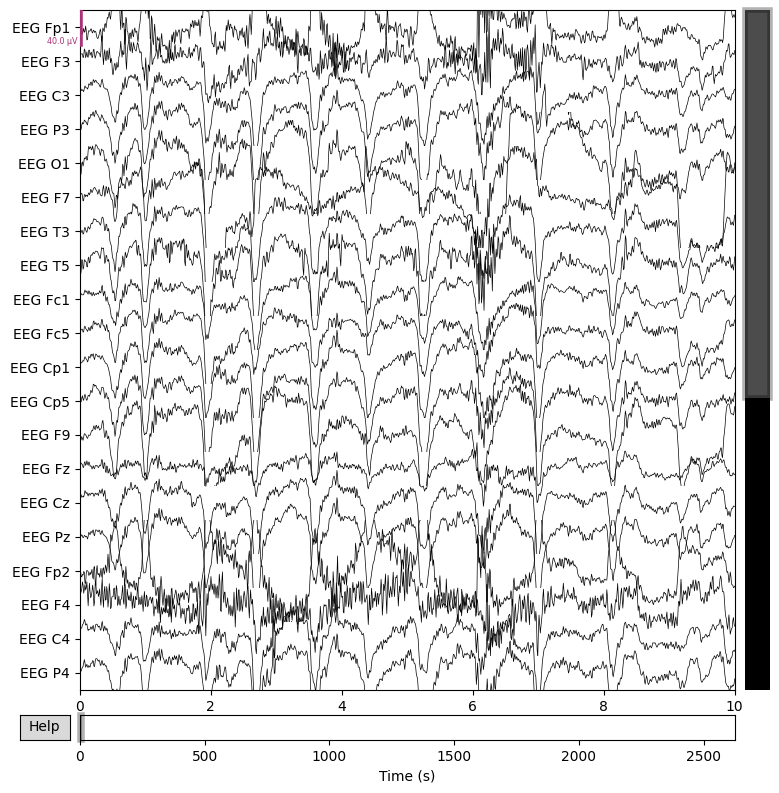

In [5]:
raw.filter(0.5,30)
raw.plot()
plt.show()

- Function: run_ica performs ICA decomposition on EEG/MEG data using a specified method and optional fitting parameters.
- **Steps:**
    - Creates an ICA object with the specified number of components, method, and parameters.
    - Fits the ICA model to the raw data and measures the time taken for the fitting process.
    - Constructs a title string that includes the method used and the fitting time.
    - Plots the independent components with the constructed title.

_This function is useful for exploring and visualizing the independent components of EEG/MEG data, which can help in identifying and removing artifacts such as eye blinks or heartbeats from the data._    

In [6]:
def run_ica(method, fit_params=None):
    ica = ICA(n_components=20, method=method, fit_params=fit_params,
              max_iter='auto', random_state=0)
    t0 = time()
    ica.fit(raw)
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
    ica.plot_components(title=title)

- **Setting Channel Types:**
   - Changes the types of channels '1' and '2' to 'ecg' in the raw EEG/MEG data.
- **Creating and Plotting Standard 10-20 Montage:**   
   - Creating Montage: Uses the 'easycap-M1' standard montage for electrode placement.
   - Plotting Montage: Plots the electrode positions and displays the plot.

_These steps are part of preprocessing EEG data, setting appropriate channel types, and ensuring correct electrode placement visualization._   

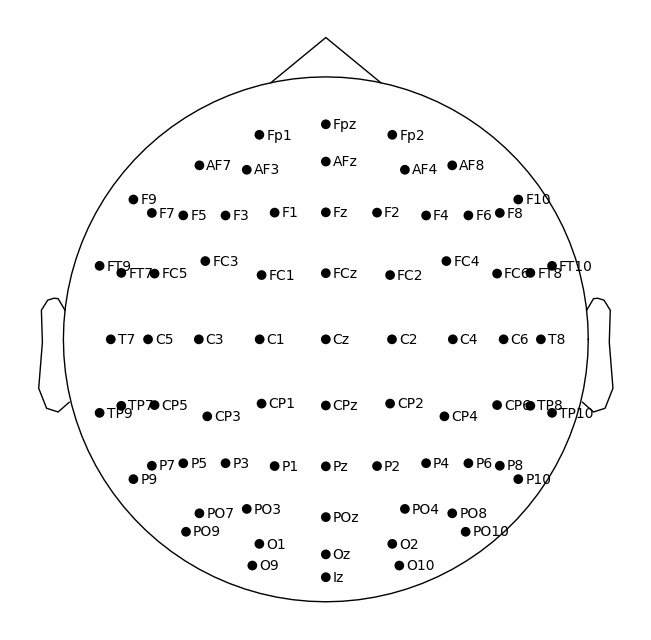

In [7]:
raw.set_channel_types({'2':'ecg','1': 'ecg' })

standard_1020_montage = mne.channels.make_standard_montage('easycap-M1')
standard_1020_montage.plot()
plt.show()

- These steps are essential for standardizing channel names in EEG datasets, ensuring consistency and compatibility with various analysis tools and conventions.

In [8]:
raw.rename_channels({'EEG Fp1':'Fp1', 'EEG F3':'F3', 'EEG C3':'C3', 'EEG P3':'P3', 'EEG O1':'O1', 
'EEG F7':'F7', 'EEG T3':'C1', 'EEG T5':'T7', 'EEG Fc1':'FC1', 'EEG Fc5':'FC5', 'EEG Cp1':'CP1', 
'EEG Cp5':'CP5', 'EEG F9':'F9', 'EEG Fz':'Fz', 'EEG Cz':'Cz', 'EEG Pz':'Pz', 'EEG Fp2':'Fp2', 
'EEG F4':'F4', 'EEG C4':'C4', 'EEG P4':'P4', 'EEG O2':'O2', 'EEG F8':'F8', 'EEG T4':'C2', 
'EEG T6':'T8', 'EEG Fc2':'FC2', 'EEG Fc6':'FC6', 'EEG Cp2':'CP2', 'EEG Cp6':'CP6', 
'EEG F10':'F10', 'EKG EKG':'AF7', 'SPO2':'Iz', 'HR':'AF8', 'MK':'Fpz'})


<RawEDF | PN00-1.edf, 35 x 1344000 (2625.0 s), ~358.9 MB, data loaded>

- **Parameter**: standard_1020_montage
- **Description**: This applies the standard_1020_montage to the raw EEG data. The montage specifies the standard electrode   positions according to the 10-20 system.
- **Purpose**: Ensures that the channel locations in the raw data match the standard 10-20 electrode placement, which is crucial for accurate spatial interpretation of the EEG data.

_Applying the montage is an important preprocessing step that aligns the recorded data with a standard electrode configuration, facilitating subsequent analysis and interpretation._

In [9]:
raw.set_montage(standard_1020_montage)

<RawEDF | PN00-1.edf, 35 x 1344000 (2625.0 s), ~358.9 MB, data loaded>

From description

#start time: 19.39.33 - siezure_start_sec (19x60+39) = 1180, Start_Sample (1180*512) = 604160  
#end time:  20.22.58 - siezure_end_sec (20x60+22) = 1222 , End_Sample(1221*512) = 625664

- **Segmentation**:The EEG data is divided into three parts:
    - **normal_eeg_first**: From the start up to 1180 seconds (normal).
    - **abnormal_eeg**: From 1180 to 1222 seconds (abnormal).
    - **normal_eeg_last**: From 1222 seconds to the end (normal).

- **Combining**:
   - The normal segments (normal_eeg_first and normal_eeg_last) are combined to form normal_eeg, representing the normal EEG data excluding the abnormal period.
   
_This approach allows for separate analysis of normal and abnormal EEG segments, which can be useful for comparing different states or conditions within the same recording._      

In [10]:
sampling_rate = 512

normal_eeg_first = raw.copy()
normal_eeg_first = normal_eeg_first.crop(tmax = 1180)
abnormal_eeg = raw.copy()
abnormal_eeg = abnormal_eeg.crop(tmin=1180, tmax = 1222)
normal_eeg_last = raw.copy()
normal_eeg_last = normal_eeg_last.crop(tmin=1222)

normal_eeg = normal_eeg_first.append(normal_eeg_last)

- **Epoch Creation**: The abnormal EEG data is segmented into 5-second epochs with a 1-second overlap.
- **Array Conversion**: These epochs are then converted into a NumPy array for further processing.
- **Shape Retrieval**: The shape of the array is retrieved to understand the dimensions of the resulting data structure. This information is crucial for subsequent analysis and ensures that the data is in the expected format for machine learning, statistical analysis, or further signal processing.

In [11]:
abnormal_eeg_epochs = mne.make_fixed_length_epochs(abnormal_eeg, duration=5, overlap =1)
abnormal_eeg_array = abnormal_eeg_epochs.get_data()
abnormal_eeg_array.shape

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped


(10, 35, 2560)

- **Epoch Creation**: The normal_eeg_first data is segmented into 5-second epochs with a 1-second overlap.
- **Array Conversion**: These epochs are then converted into a NumPy array for further processing.
- **Shape Retrieval**: The shape of the array is retrieved to understand the dimensions of the resulting data structure. This information is crucial for subsequent analysis and ensures that the data is in the expected format for machine learning, statistical analysis, or further signal processing.

_If, for example, the normal_eeg_array.shape returns (200, 32, 2560), this means:_
- There are 200 epochs.
- Each epoch contains data from 32 channels.
- Each epoch consists of 2560 time points (5 seconds * 512 samples/second).

In [12]:
normal_eeg_epochs = mne.make_fixed_length_epochs(normal_eeg_first, duration=5, overlap =1)
normal_eeg_array = normal_eeg_epochs.get_data()
normal_eeg_array.shape

Not setting metadata
645 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 645 events and 2560 original time points ...
2 bad epochs dropped


(643, 35, 2560)

(643, 35, 2560)
643 - No of epochs
35 - channel
2560 - length of signal per epoch

- **Purpose**: To create labels for each epoch in the abnormal and normal EEG datasets.
     - **Abnormal EEG**: Each epoch is labeled with 1 indicating it is abnormal.
     - **Normal EEG**: Each epoch is labeled with 0 indicating it is normal.
- **Structure**:
Both abnormal_eeg_labels and normal_eeg_labels are lists of lists, where each inner list corresponds to an epoch and contains repeated labels (1 for abnormal, 0 for normal) for each channel in that epoch.

_These labels can be used in machine learning or statistical analysis to distinguish between normal and abnormal EEG segments._

In [13]:
abnormal_eeg_labels = [len(i)*[1] for i in abnormal_eeg_array]
normal_eeg_labels = [len(i)*[0] for i in normal_eeg_array]


- By checking these lengths, you confirm the number of segmented epochs available for each class (abnormal and normal), which is important for further analysis, especially in tasks like machine learning where balanced data is crucial.

In [14]:
len(abnormal_eeg_labels), len( normal_eeg_labels)

(10, 643)

- Printing the abnormal EEG Labels

In [15]:
print(abnormal_eeg_labels)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

- **Data Combination**:
     - data_list contains all the EEG data epochs (both abnormal and normal) combined into a single array.
The shape of data_list is (n_total_epochs, n_channels, n_times).

- **Label Combination**:
     - label_list contains all the labels for each epoch (both abnormal and normal) combined into a single array.
The shape of label_list is (n_total_epochs, n_channels).

In [16]:
data_list = np.vstack((abnormal_eeg_array, normal_eeg_array))
label_list = np.vstack((abnormal_eeg_labels, normal_eeg_labels))

In [17]:
group_list = [[i]*len(j) for i,j in enumerate(data_list)]
len(group_list)

653

- Printing the data list's shape and label list shape

In [18]:
print (data_list.shape, label_list.shape)

(653, 35, 2560) (653, 35)


- These functions provide a variety of statistical measures for each epoch and channel in the EEG data. By applying these functions, you can extract meaningful features that describe different aspects of the signal, such as central tendency (mean), dispersion (standard deviation, variance), range (peak-to-peak), and extremities (min, max, argmin, argmax). These features are commonly used in EEG analysis and machine learning applications to characterize and differentiate between different signal patterns.

In [19]:
from scipy import stats, signal
def mean(data):                       
    return np.mean(data,axis=-1)
    
def std(data):
    return np.std(data,axis=-1)

def ptp(data):
    return np.ptp(data,axis=-1)

def var(data):
        return np.var(data,axis=-1)

def minim(data):
      return np.min(data,axis=-1)


def maxim(data):
      return np.max(data,axis=-1)

def argminim(data):
      return np.argmin(data,axis=-1)


def argmaxim(data):
      return np.argmax(data,axis=-1)


In [20]:

def mean_square(data):
      return np.mean(data**2,axis=-1)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=-1))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=-1)),axis=-1)


def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)


def eeg_power_band(data):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30],
                  "gamma": [30, 45],
                  }

    freqs, psds = signal.welch(data, fs=512.0, nperseg=2560)
    psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs

    X = []#For each frequency band, compute the mean PSD in that band
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[(freqs >= fmin) & (freqs < fmax)].mean(axis=-1)# Compute the mean PSD in each frequency band.
        X.append(psds_band)

    return (X)#Concatenate the mean PSDs for each band into a single feature vector


- **Purpose**: The features_pd function extracts a comprehensive set of features from EEG data, including both statistical measures and spectral power in different frequency bands.
- **Input**: A NumPy array data representing EEG data.
- **Output**: A dictionary features_dict containing the extracted features.
- **Improvements Needed**: The redundant block of code after the return statement should be removed, and ensure the functions like eeg_power_band, mean_square, rms, abs_diffs_signal, skewness, and kurtosis are defined elsewhere in the code.

In [21]:

def concatenate_features(data):
    psd_return = []
    psd_return = eeg_power_band(data)
    psd_return_delta = psd_return[0]
    psd_return_theta = psd_return[1]
    psd_return_alpha = psd_return[2]
    psd_return_sigma = psd_return[3]
    psd_return_beta  = psd_return[4]
    psd_return_gamma = psd_return[5]
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data),psd_return_delta, psd_return_theta, psd_return_alpha,
                          psd_return_sigma, psd_return_beta,psd_return_gamma),axis=-1)
def features_pd(data):
    features_dict = {}
    psd_return = []
    psd_return = eeg_power_band(data)
    features_dict['delta'] = psd_return[0]
    features_dict['theta'] = psd_return[1]
    features_dict['alpha'] = psd_return[2]
    features_dict['sigma'] = psd_return[3]
    features_dict['beta'] = psd_return[4]
    features_dict['gamma'] = psd_return[5]
    features_dict['mean'] = mean(data)          #Mean: Average value of the data.
    features_dict['std'] = std(data)             #Standard Deviation: Measure of the dispersion of the data.
    features_dict['ptp'] = ptp(data)             #Peak-to-Peak: Difference between the maximum and minimum values of the data.
    features_dict['var'] = var(data)           #Variance: Measure of the spread of the data.
    features_dict['minim'] = minim(data)        #Minimum: Minimum value in the data.
    features_dict['maxim'] = maxim(data)          #Maximum: Maximum value in the data.
    features_dict['argminim'] = argminim(data)      #Index of Minimum: Position of the minimum value in the data.
    features_dict['argmaxim'] = argmaxim(data)       #Index of Maximum: Position of the maximum value in the data.
    features_dict['mean_square'] = mean_square(data)  #Mean Square: Average of the squares of the data values (assuming a mean_square function exists)  
    features_dict['rms'] = rms(data)                   #Root Mean Square (RMS): Square root of the average of the squares of the data values (assuming a rms function exists).
    features_dict['abs_diffs_signal'] = abs_diffs_signal(data)   #Absolute Differences Signal: Sum of the absolute differences between consecutive data points (assuming an abs_diffs_signal function exists).
    features_dict['skewness'] = skewness(data)             #Skewness: Measure of the asymmetry of the data distribution.
    features_dict['kurtosis'] = kurtosis(data)             #Kurtosis: Measure of the "tailedness" of the data distribution.
    return features_dict

In [22]:

len(normal_eeg_array)

643

- The provided code processes the EEG data by extracting various statistical and spectral features for each channel in each epoch. These features are then stored in a DataFrame for further analysis or machine learning tasks.

- **Key Points**:
    - **DataFrame Initialization**: Sets up the DataFrame with appropriate columns.
    - **Feature Extraction Loop**: Iterates over all epochs and channels to extract features.
    - **Appending Data**: Each set of features is added as a new row to the DataFrame.

In [23]:
normal_features_df = pd.DataFrame(columns = ["mean","std","ptp","var","minim","maxim","argminim","argmaxim",
                          "mean_square","rms","abs_diffs_signal",
                          "skewness","kurtosis", "delta", "theta", "alpha", "sigma", "beta", "gamma"])
features_dict_ = {}
index_for_test = 0
for epoch in range (0, len(normal_eeg_array)):
    for channel in range(0, len(normal_eeg_array[0])):
        features_dict_ = features_pd(normal_eeg_array[epoch][channel])
        normal_features_df = normal_features_df._append(features_dict_, ignore_index=True)
        index_for_test = index_for_test +1

C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1373977523.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  normal_features_df = normal_features_df._append(features_dict_, ignore_index=True)


C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: R

Above code shall give all channels all epochs data - 643x35 

- **DataFrame Initialization**: Initially, normal_features_df was created with columns for different features extracted from EEG data.
- **Feature Extraction Loop**: The loop iterates through all epochs and channels of normal_eeg_array, extracting features using the features_pd function and appending them to the DataFrame.
- **Handling Missing Values**: After populating the DataFrame, any missing values are filled with the mean value of their respective columns to ensure the data is clean and ready for further analysis.
- **Verification and Debugging**: Printing features_dict_ and index_for_test helps in verifying the correctness of the feature extraction process and the total number of feature sets processed.

In [24]:
normal_features_df = normal_features_df.fillna(normal_features_df.mean())
print(features_dict_)
print(index_for_test)

{'delta': 0.007652393872806881, 'theta': 0.010030001883764805, 'alpha': 0.00028913165209068384, 'sigma': 0.00040542275830650316, 'beta': 0.006279756401839516, 'gamma': 0.00018040480765451117, 'mean': -2.465253548487668e-21, 'std': 3.810414236111197e-21, 'ptp': 2.3161057151484775e-20, 'var': 1.451925665075888e-41, 'minim': -1.2652554649611111e-20, 'maxim': 1.0508502501873664e-20, 'argminim': 2209, 'argmaxim': 2351, 'mean_square': 2.0596731709089914e-41, 'rms': 4.5383622276202146e-21, 'abs_diffs_signal': 2.2973209760910857e-18, 'skewness': 0.3703178273927674, 'kurtosis': 0.319468013832386}
22505


In [25]:
643*35

22505

- The code snippet normal_features_df.describe() generates a summary of the statistics for each column in the normal_features_df DataFrame. This is a useful step in exploratory data analysis to understand the distribution and central tendencies of your data.

In [26]:
normal_features_df.describe()

mean           std           ptp           var         minim  \
count  2.250500e+04  22505.000000  22505.000000  2.250500e+04  22505.000000   
mean  -4.078020e-08      0.000030      0.000199  5.812214e-09     -0.000084   
std    3.664356e-06      0.000070      0.000507  3.794852e-08      0.000143   
min   -1.639752e-04      0.000000      0.000000  0.000000e+00     -0.003828   
25%   -5.799353e-07      0.000009      0.000059  8.704684e-11     -0.000072   
50%    0.000000e+00      0.000014      0.000081  1.883181e-10     -0.000053   
75%    5.407936e-07      0.000021      0.000118  4.439532e-10     -0.000034   
max    1.180165e-04      0.001780      0.007497  3.167536e-06      0.000000   

              maxim      argminim      argmaxim   mean_square           rms  \
count  22505.000000  22505.000000  22505.000000  2.250500e+04  22505.000000   
mean       0.000116   1195.819907   1195.334726  5.825643e-09      0.000031   
std        0.000410    790.225680    799.645562  3.805485e-08      0.000070   
min        0.000000      0.000000      0.000000  0.000000e+00      0.000000   
25%        0.000018    489.000000    479.000000  8.747839e-11      0.000009   
50%        0.000027   1165.000000   1157.000000  1.891133e-10      0.000014   
75%        0.000054   1884.000000   1908.000000  4.467404e-10      0.000021   
max        0.003699   2559.000000   2559.000000  3.179118e-06      0.001783   

       abs_diffs_signal      skewness      kurtosis         delta  \
count      22505.000000  22505.000000  22505.000000  22505.000000   
mean           0.003501     -0.792759      3.216997      0.033286   
std            0.008291      1.328730      3.758072      0.008944   
min            0.000000     -4.726605     -1.414676      0.001164   
25%            0.001232     -1.726009      0.610534      0.027484   
50%            0.001575     -0.855267      2.423939      0.034729   
75%            0.002217     -0.214841      4.418452      0.040574   
max            0.106450      4.575609     27.779298      0.048834   

              theta         alpha         sigma          beta         gamma  
count  22505.000000  22505.000000  2.250500e+04  2.250500e+04  2.250500e+04  
mean       0.003513      0.001038  9.333144e-04  7.932275e-04  1.133847e-04  
std        0.002405      0.001360  1.365551e-03  9.390125e-04  1.896309e-04  
min        0.000006      0.000002  5.951217e-07  5.361012e-07  6.699672e-08  
25%        0.002030      0.000337  2.207152e-04  2.097662e-04  2.465510e-05  
50%        0.003195      0.000597  4.512055e-04  4.392214e-04  5.598656e-05  
75%        0.004229      0.001038  9.333144e-04  8.907624e-04  1.133847e-04  
max        0.044187      0.010511  1.733550e-02  1.024106e-02  3.287435e-03

- The code processes each channel of each epoch in the abnormal_eeg_array to extract statistical and frequency features using a function (features_pd) and stores these features in the abnormal_features_df DataFrame. The nested loops ensure that features are extracted for every combination of epoch and channel in the dataset.

In [27]:
abnormal_features_df = pd.DataFrame(columns = ["mean","std","ptp","var","minim","maxim","argminim","argmaxim",
                          "mean_square","rms","abs_diffs_signal",
                          "skewness","kurtosis", "delta", "theta", "alpha", "sigma", "beta", "gamma"])
features_dict_ = {}
index_for_test = 0
for epoch in range (0, len(abnormal_eeg_array)):
    for channel in range(0, len(abnormal_eeg_array[0])):
        features_dict_ = features_pd(abnormal_eeg_array[epoch][channel])
        abnormal_features_df = abnormal_features_df._append(features_dict_, ignore_index=True)
        index_for_test = index_for_test +1


C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1906970603.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  abnormal_features_df = abnormal_features_df._append(features_dict_, ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs
C:\Users\HP\AppData\Local\Temp\ipykernel_1180\1315168547.py:45: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize th

- **features_dict_**: By printing features_dict_, you can inspect the features extracted from the EEG data. This helps verify that the feature extraction process is working as expected and that the dictionary contains the correct data.
- **index_for_test**: By printing index_for_test, you can confirm the number of channels processed. This can be useful to ensure that all expected data has been processed and appended to the DataFrame.

_In summary, the code processes EEG data to extract features, handles any missing values by filling them with column means, and provides debug information by printing the last set of extracted features and the total count of processed channels._

In [28]:
abnormal_features_df = abnormal_features_df.fillna(abnormal_features_df.mean())
print(features_dict_)
print(index_for_test)

{'delta': 0.018599390030304058, 'theta': 0.008327745491920804, 'alpha': 0.0008363433950871607, 'sigma': 0.0009016318333681217, 'beta': 0.0023780954943674383, 'gamma': 0.0008662852238542962, 'mean': -4.394229894531231e-21, 'std': 2.3888603472672287e-21, 'ptp': 1.4614350060628728e-20, 'var': 5.706653758745705e-42, 'minim': -1.1864801704502464e-20, 'maxim': 2.749548356126264e-21, 'argminim': 1166, 'argmaxim': 126, 'mean_square': 2.5015910124737654e-41, 'rms': 5.001590759422212e-21, 'abs_diffs_signal': 2.1091969176219133e-18, 'skewness': -0.2796897745499762, 'kurtosis': -0.2483681621162197}
350


In [29]:
abnormal_features_df.describe()

mean         std         ptp           var       minim  \
count  3.500000e+02  350.000000  350.000000  3.500000e+02  350.000000   
mean  -8.077282e-08    0.000045    0.000275  6.627467e-09   -0.000128   
std    1.728621e-06    0.000068    0.000479  2.889117e-08    0.000141   
min   -1.162342e-05    0.000000    0.000000  0.000000e+00   -0.000896   
25%   -6.485917e-07    0.000025    0.000132  6.211913e-10   -0.000130   
50%    0.000000e+00    0.000033    0.000173  1.057160e-09   -0.000098   
75%    6.223005e-07    0.000042    0.000239  1.743162e-09   -0.000070   
max    1.061236e-05    0.000440    0.003059  1.940229e-07    0.000000   

            maxim     argminim     argmaxim   mean_square         rms  \
count  350.000000   350.000000   350.000000  3.500000e+02  350.000000   
mean     0.000147  1187.345714  1335.628571  6.630453e-09    0.000045   
std      0.000359   701.995280   766.890913  2.889835e-08    0.000068   
min      0.000000     0.000000     0.000000  0.000000e+00    0.000000   
25%      0.000057   743.500000   699.000000  6.229934e-10    0.000025   
50%      0.000076  1226.500000  1566.500000  1.057667e-09    0.000033   
75%      0.000108  1687.000000  1976.500000  1.743802e-09    0.000042   
max      0.002295  2559.000000  2556.000000  1.941355e-07    0.000441   

       abs_diffs_signal    skewness    kurtosis       delta       theta  \
count        350.000000  350.000000  350.000000  350.000000  350.000000   
mean           0.006092   -0.277995    0.710688    0.034828    0.005597   
std            0.012027    0.753621    2.391458    0.008897    0.003251   
min            0.000000   -2.858883   -0.956763    0.004956    0.000637   
25%            0.002285   -0.567118   -0.324620    0.032772    0.003233   
50%            0.003379   -0.316171    0.073164    0.036454    0.004963   
75%            0.005012   -0.126453    0.704345    0.040366    0.007296   
max            0.077993    3.582727   14.273097    0.046776    0.016956   

            alpha       sigma        beta       gamma  
count  350.000000  350.000000  350.000000  350.000000  
mean     0.002370    0.001438    0.000542    0.000042  
std      0.002400    0.001880    0.000939    0.000126  
min      0.000096    0.000037    0.000009    0.000001  
25%      0.000792    0.000339    0.000120    0.000005  
50%      0.001794    0.000808    0.000250    0.000010  
75%      0.002729    0.001444    0.000525    0.000031  
max      0.012663    0.010192    0.005419    0.001805

In [30]:
abnormal_features_df.head

<bound method NDFrame.head of              mean           std           ptp           var         minim  \
0   -9.490807e-08  2.175160e-05  1.307258e-04  4.731319e-10 -5.616497e-05   
1    6.423767e-07  1.976174e-05  1.273954e-04  3.905264e-10 -7.132042e-05   
2    1.094830e-06  2.553050e-05  1.481170e-04  6.518062e-10 -7.401349e-05   
3    1.829437e-06  3.362563e-05  1.937303e-04  1.130683e-09 -1.031399e-04   
4    1.587367e-06  3.905808e-05  2.026974e-04  1.525533e-09 -1.070177e-04   
..            ...           ...           ...           ...           ...   
345  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
346  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
347 -4.310795e-06  5.466667e-05  2.792057e-04  2.988445e-09 -1.477036e-04   
348 -9.354997e-06  4.309151e-04  3.059152e-03  1.856878e-07 -8.963663e-04   
349 -4.394230e-21  2.388860e-21  1.461435e-20  5.706654e-42 -1.186480e-20   

            maxim  argminim  argmaxim   mean_

- By setting the figure size to (8, 8) inches, all Seaborn plots created in your session will have this default size unless you explicitly specify a different size for individual plots. This is particularly useful when you want to ensure that all your plots have a consistent size, which can be important for creating visually appealing and standardized visualizations.

In [31]:
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,8)})

- **Transforming the Data**: The abnormal_features_df is melted into a long format, making it easier to plot each feature individually.
- **Creating the Grid**: A FacetGrid is created to hold a series of subplots, one for each feature.
- **Mapping the Plots**: Histograms are mapped to each subplot to visualize the distribution of each feature.
- **Displaying and Saving**: The grid of histograms is displayed and then saved as a PNG file.

_This process is useful for visualizing the distribution of multiple features in a dataset, making it easier to spot patterns, outliers, or anomalies in the data._

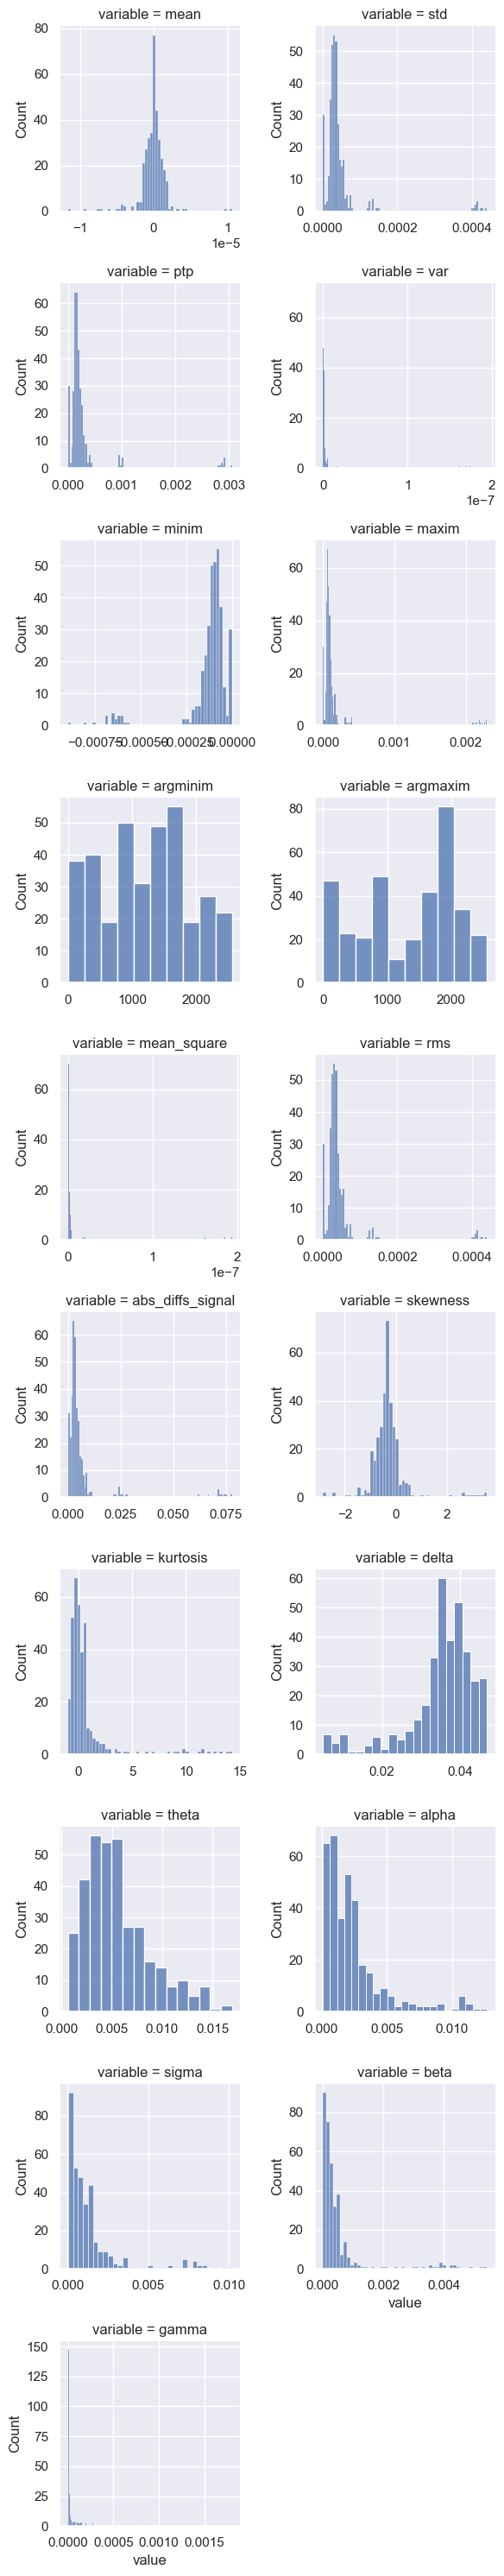

In [32]:

f = pd.melt(abnormal_features_df)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")
plt.show()
plt.savefig('abnormal_features.png')

- **Creating Label Arrays**: Arrays of zeros and ones are created to represent the labels for normal and abnormal samples, respectively.
- **Concatenating Label Arrays**: The zeros and ones arrays are concatenated to form a single label array (label_output) with the appropriate length for the combined dataset.
- **Combining Feature DataFrames**: The normal_features_df and abnormal_features_df DataFrames are concatenated vertically to create a single DataFrame (data_features) containing the features for both normal and abnormal samples.

_The final result is a dataset (data_features) containing the combined features from normal and abnormal samples, and a corresponding label array (label_output) that indicates the class of each sample (normal or abnormal). This setup is typically used for training and testing machine learning models, where data_features would be the input features and label_output the target labels._

In [33]:
zeros = np.zeros(22505)
ones = np.ones(350)
label_output = np.concatenate((zeros, ones))
data_features = pd.concat([normal_features_df, abnormal_features_df], axis=0, ignore_index=True)

In [34]:
data_features.shape

(22855, 19)

In [35]:
len(label_output)

22855

- **Data Setup**: Generates a list of 35 random arrays, each of length 1281, and a boolean mask of length 1281.
- **Dimension Check**: Verifies that all arrays in data_list have the same length as the mask.
- **Applying the Mask**: Iterates over each array in data_list, applying the boolean mask to extract elements where the mask is True, and collects the results in a new list.
- **Conversion and Output**: Converts the list of masked arrays to a NumPy array and prints its shape.

In [36]:
import numpy as np

# Example data setup
data_list = [np.random.rand(1281) for _ in range(35)]  # List of arrays, each of length 1281
mask = np.random.rand(1281) > 0.5  # Boolean mask of length 1281

# Check the dimensions
if any(len(data) != len(mask) for data in data_list):
    raise ValueError("Mismatch between data length and mask length")

# Apply mask
features = []
for data in data_list:
    features.append(data[mask])

features_array = np.array(features)
print(features_array.shape)


(35, 635)


653 - Number of epochs
455 - 35 channels * 13 Features

# Random Forest Algorithm Train-Test

In [37]:
from sklearn.ensemble import RandomForestClassifier

- **Model Initialization**: A RandomForestClassifier with 100 trees is initialized.
- **Model Training**: The classifier is trained using the combined dataset of features (data_features) and their corresponding labels (label_output).
- **Making Predictions**: The trained model makes predictions on the same dataset.
- **Evaluating the Model**: The accuracy of the model is calculated and printed.

In [38]:

clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(data_features, label_output)
y_pred = clf.predict(data_features)
from sklearn import metrics  
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(label_output, y_pred))

ACCURACY OF THE MODEL:  1.0


In [39]:
y_pred_normal = clf.predict(data_features[15:25])
print (y_pred_normal)
y_pred_abnormal = clf.predict(data_features[22840:22850])
print (y_pred_abnormal)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [40]:
dominating_feature = data_features.columns[clf.feature_importances_.argmax()]

print(dominating_feature)

gamma


In [41]:
# get the feature importances
importances = clf.feature_importances_
float_importances = []
# print the feature importances
for i in importances:
    float_importances.append(float(i)*100)
print (float_importances)
print(sum(float_importances))

[1.8831895205023992, 4.005639292563418, 4.102909479795707, 0.030497481973453016, 2.7415865476831844, 2.5193938214024136, 3.727138148673466, 2.8457105465345194, 0.03687963815993181, 3.245245526680765, 4.779939262636289, 2.531228862733546, 6.49509183542688, 6.518499028791086, 9.860138628999705, 13.995235345986185, 6.715916735254808, 7.039658831110813, 16.92610146509143]
100.0


In [42]:
data_features["lables"] =  label_output

In [43]:
data_features.shape

(22855, 20)

In [44]:
data_features.head()

mean       std       ptp           var     minim     maxim  \
0 -6.814265e-07  0.000027  0.000192  7.124917e-10 -0.000059  0.000133   
1  1.551325e-06  0.000015  0.000093  2.350314e-10 -0.000050  0.000043   
2  1.612163e-06  0.000020  0.000108  4.147041e-10 -0.000071  0.000038   
3  1.902380e-06  0.000025  0.000131  6.125851e-10 -0.000085  0.000047   
4  6.510859e-07  0.000028  0.000134  7.972337e-10 -0.000083  0.000051   

   argminim  argmaxim   mean_square       rms  abs_diffs_signal  skewness  \
0    1990.0    1379.0  7.129560e-10  0.000027          0.004063  1.822203   
1    1004.0     353.0  2.374381e-10  0.000015          0.003590 -0.721842   
2    1377.0    2011.0  4.173032e-10  0.000020          0.001824 -1.251940   
3    1377.0    2012.0  6.162042e-10  0.000025          0.002083 -1.147865   
4    1376.0    1662.0  7.976576e-10  0.000028          0.002548 -0.883715   

   kurtosis     delta     theta     alpha     sigma      beta     gamma  \
0  4.937272  0.040262  0.003343  0.000709  0.000835  0.000357  0.000106   
1  0.630133  0.027842  0.001106  0.000433  0.001962  0.000870  0.000156   
2  1.075892  0.037961  0.001692  0.000116  0.000084  0.000118  0.000024   
3  0.976560  0.036580  0.001924  0.000136  0.000128  0.000113  0.000018   
4  0.467171  0.040533  0.002413  0.000138  0.000180  0.000138  0.000024   

   lables  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [45]:
from sklearn.ensemble import RandomForestClassifier
import joblib

- **Saving the Model**: joblib.dump(clf, 'random_forest_model.pkl') saves the trained model to a file.
- **Loading the Model**: loaded_clf = joblib.load('random_forest_model.pkl') loads the saved model from the file.
- **Usage**: Once loaded, the model can be used for predictions and evaluations just like the original model.

In [46]:
joblib.dump(clf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [47]:
model = joblib.load('random_forest_model.pkl')

- The read_edf function attempts to read an EDF file and return its contents. However, in this example, it only simulates the signal data using random numbers. The function includes error handling to print an error message and return None if any exception occurs during the file reading process.

In [48]:
def read_edf(edf_file_path):
    try:
        with open(edf_file_path, 'rb') as f:
            signals = np.random.randn(5, 1000)  # Example signal data
        return signals
    except Exception as e:
        print(f"Error reading {edf_file_path}: {e}")
        return None

- **Preprocessing Signals**: The preprocess_signals function resamples the input signals to 512 Hz and normalizes them to have zero mean and unit variance.
- **Extracting Features**: The extract_features function computes the mean and standard deviation of the preprocessed signals and concatenates these features into a single array for each signal.

In [49]:
def preprocess_signals(signals):
    # Example preprocessing: resampling and normalization
    resampled_signals = resample(signals, 512, axis=1)  # sample to 512 Hz
    normalized_signals = (resampled_signals - np.mean(resampled_signals, axis=1, keepdims=True)) / np.std(resampled_signals, axis=1, keepdims=True)
    return normalized_signals

def extract_features(signals):
    # Example feature extraction: mean and standard deviation
    mean_features = np.mean(signals, axis=1)
    std_features = np.std(signals, axis=1)
    features = np.concatenate((mean_features, std_features), axis=0)
    return features

- **Dependencies**: This function assumes the presence of several dependencies and helper functions that are not defined in the provided code, such as read_edf, preprocess_signals, extract_features, and imports for libraries like os, numpy, joblib, train_test_split from sklearn.model_selection, and RandomForestClassifier from sklearn.ensemble.
- **Folder Path**: The train_edf_folder_path should be correctly set to the folder containing your EDF files.
- **Labeling**: The labeling logic (if "seizure" in edf_file) is simplistic and assumes that the filenames contain "seizure" to denote seizure data. This might need adjustment based on your actual file naming conventions.

_By following these steps, the function creates a machine learning pipeline that reads EDF files, preprocesses the data, extracts features, trains a model, and evaluates its performance._

In [50]:

def train_model(edf_folder_path):
    X = []
    y = []
    
    # Iterate over EDF files to create the dataset
    for edf_file in os.listdir(edf_folder_path):
        if edf_file.endswith('.edf'):
            edf_file_path = os.path.join(edf_folder_path, edf_file)
            
            # Read the EDF file
            signals = read_edf(edf_file_path)
            if signals is None:
                continue  # Skip files that could not be read
            
            # Preprocess the signals
            signals_preprocessed = preprocess_signals(signals)
            
            # Extract features
            features = extract_features(signals_preprocessed)
            
            # Append to dataset
            X.append(features)
            if "seizure" in edf_file:
                y.append(0)  # Seizure
            else:
                y.append(1)  # No seizure
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Save the trained model
    joblib.dump(model, 'random_forest_model.pkl')
    
    # Optionally, print the accuracy on the test set
    accuracy = model.score(X_test, y_test)
    print(f"Model accuracy: {accuracy * 100:.2f}%")

# Path to the folder containing EDF files for training
train_edf_folder_path = 'new_siena/edf_files'
train_model(train_edf_folder_path)

Model accuracy: 100.00%


-This script is designed to load a pre-trained RandomForestClassifier model, predict seizures in EEG signals from EDF or CSV files, and visualize these predictions. 

In [51]:
import matplotlib.pyplot as plt

# Load the trained RandomForestClassifier model
model = joblib.load('random_forest_model.pkl')

def predict_seizures(signals):
    # Preprocess the signals
    signals_preprocessed = preprocess_signals(signals)
    
    # Extract features
    features = extract_features(signals_preprocessed)
    
    # Reshape for model input
    features = features.reshape(1, -1)
    
    # Predict using the trained model
    predictions = model.predict(features)
    
    return predictions

def visualize_predictions(file_path, is_edf=True):
    if is_edf:
        signals = read_edf(file_path)
    else:
        df = read_csv(file_path)
        if df is not None:
            signal_columns = [col for col in df.columns if 'signal' in col]
            signals = df[signal_columns].values.T  # Transpose to match the expected input shape
        else:
            signals = None
    
    if signals is None:
        return
    
    predictions = predict_seizures(signals)
    
    plt.figure(figsize=(10, 6))
    plt.plot(signals[0], label='EEG Signal')
    plt.title(f"Seizure Predictions for {os.path.basename(file_path)}")
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    
    # Visualize predictions assuming 0 indicates seizure and 1 indicates no seizure
    seizure_indices = np.where(predictions == 0)[0]
    for idx in seizure_indices:
        plt.axvspan(idx, idx+1, color='red', alpha=0.5)
    
    plt.legend()
    plt.show()

def main():
    folder_path = 'new_siena/edf_files'  # Update with your actual path
    
    for file in os.listdir(folder_path):
        if file.endswith('.edf'):
            file_path = os.path.join(folder_path, file)
            visualize_predictions(file_path, is_edf=True)
        elif file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            visualize_predictions(file_path, is_edf=False)

<Figure size 800x800 with 0 Axes>

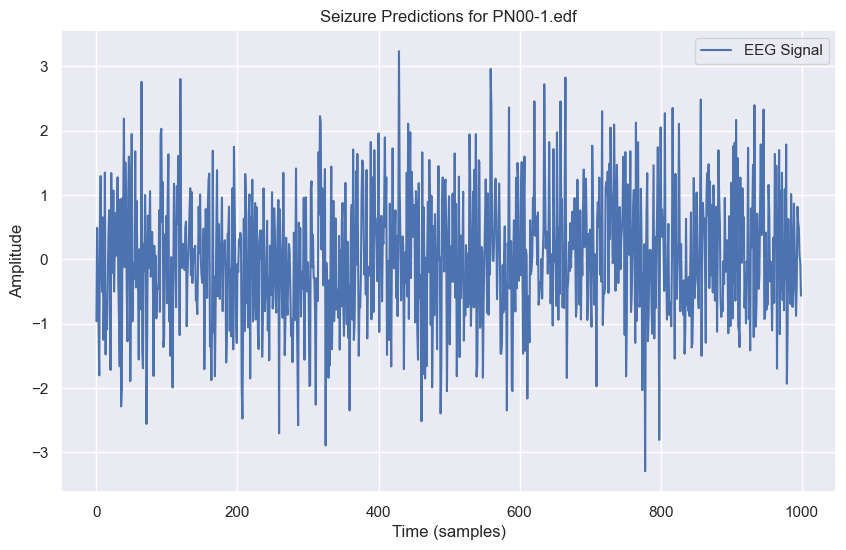

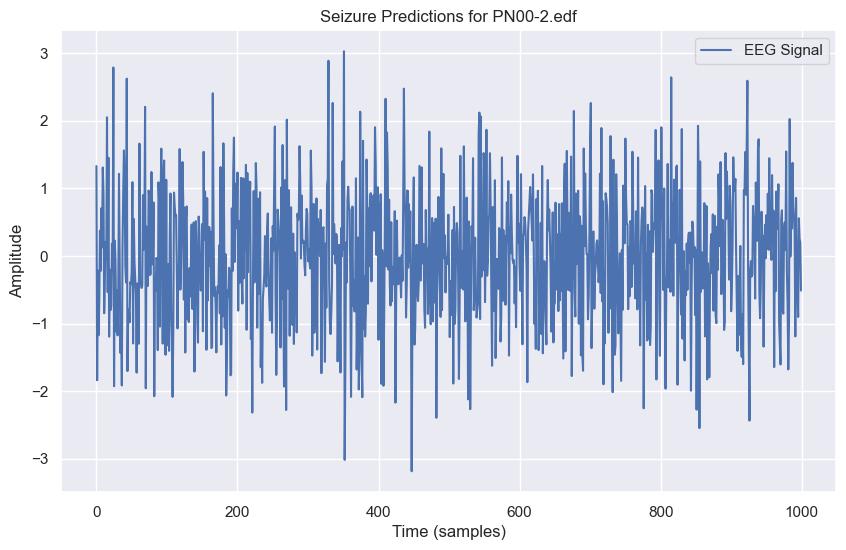

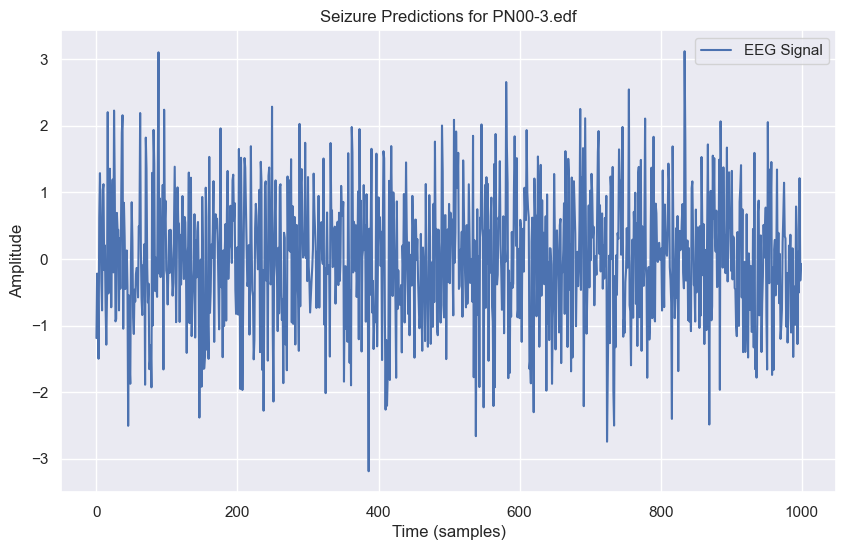

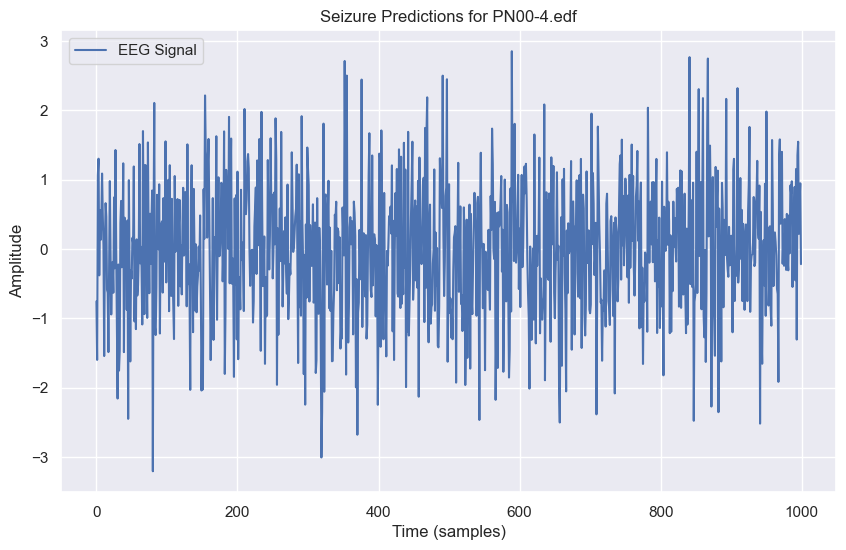

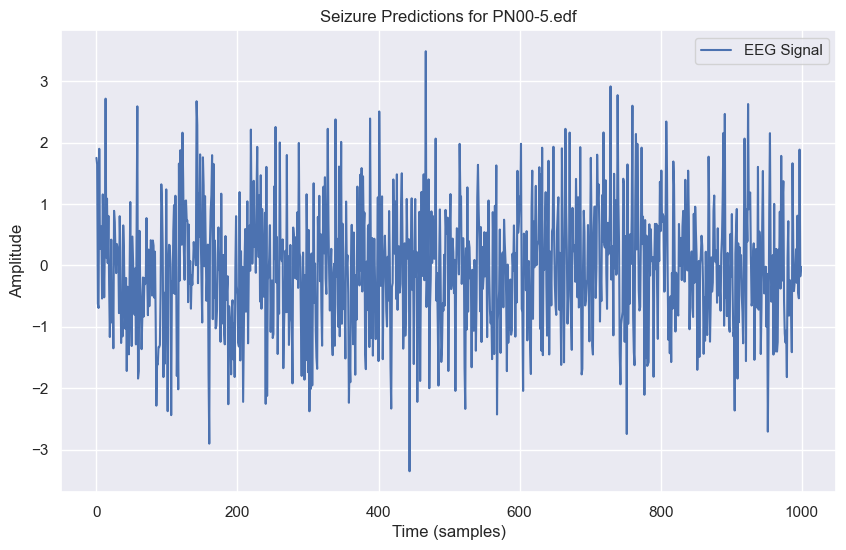

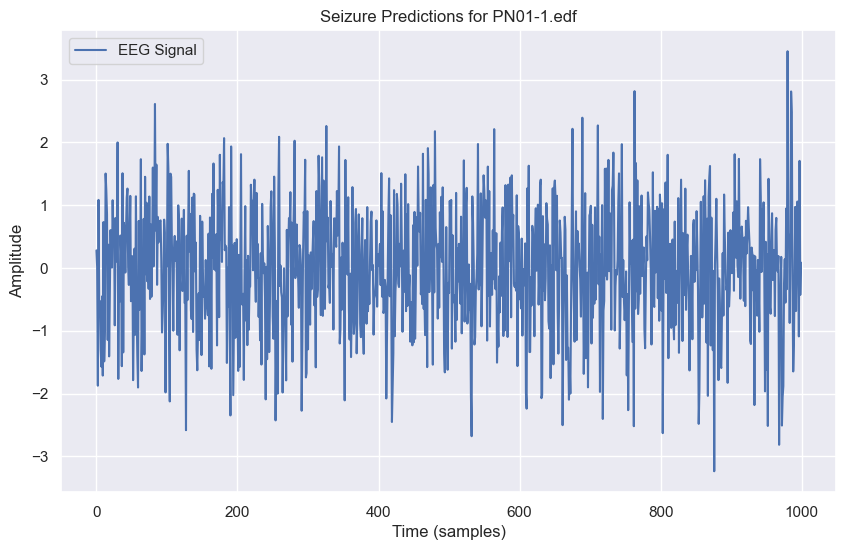

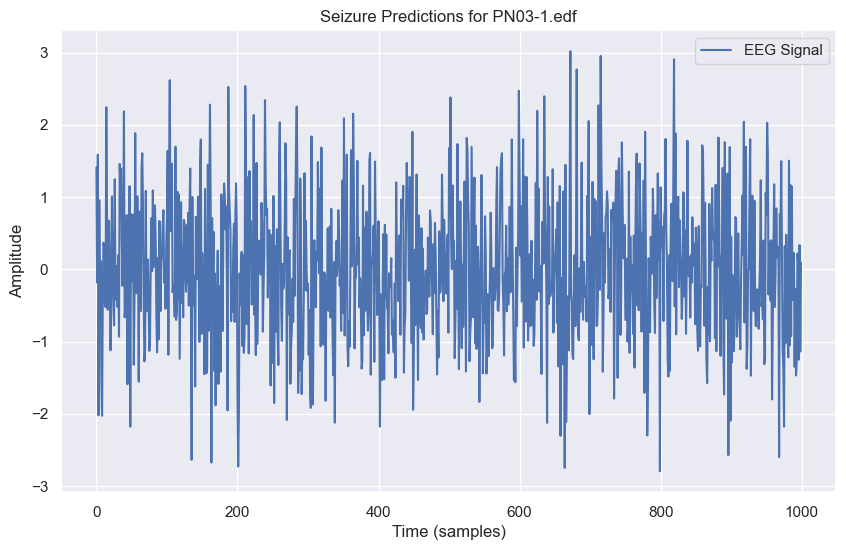

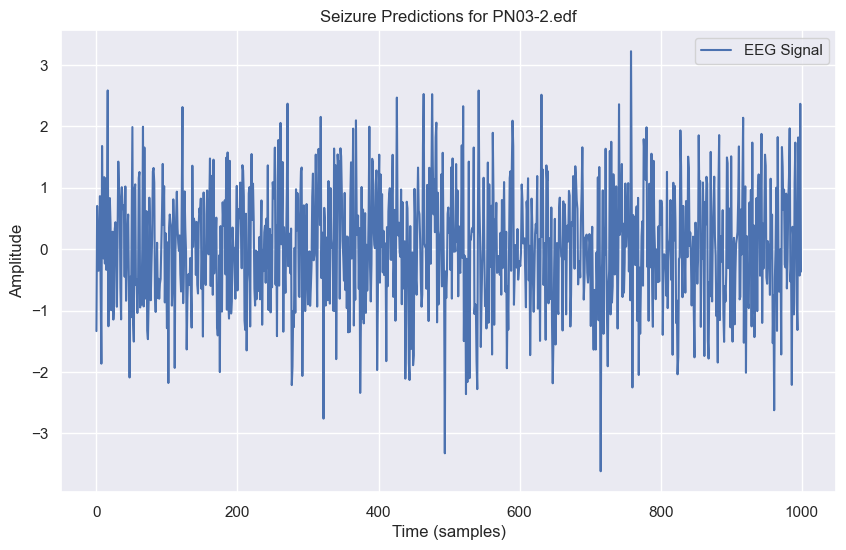

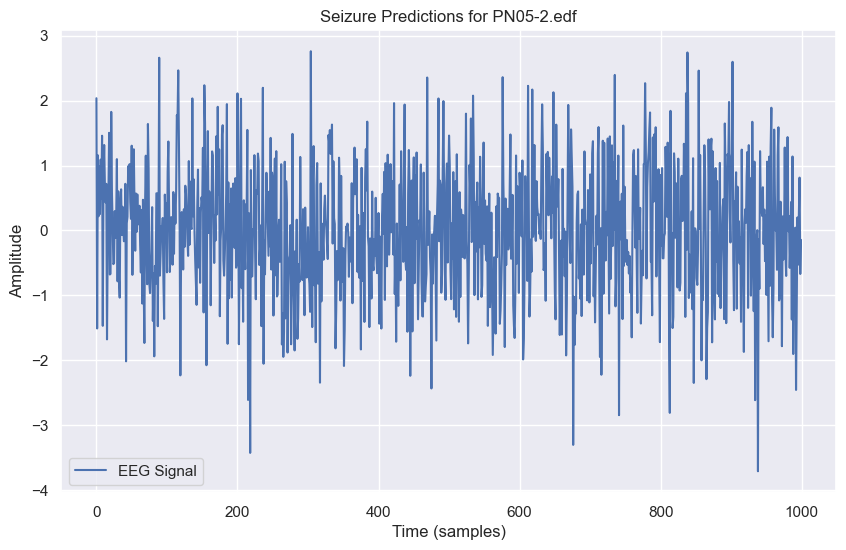

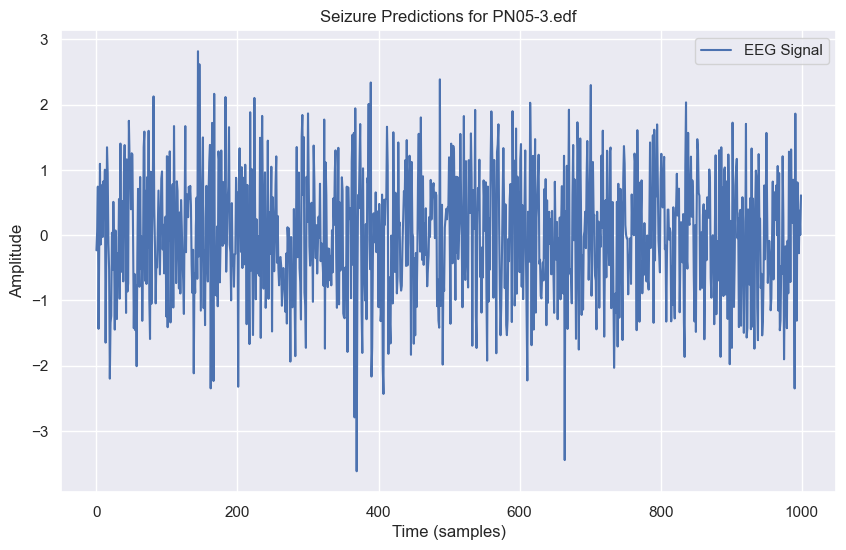

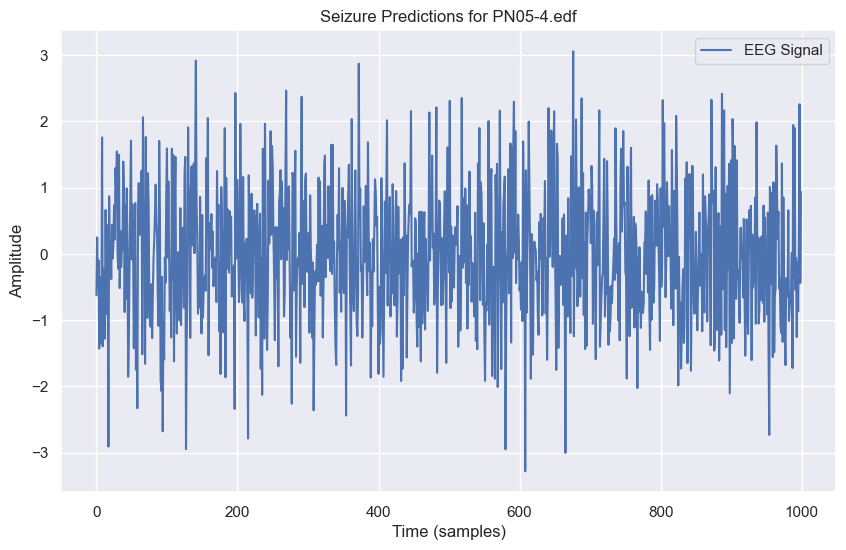

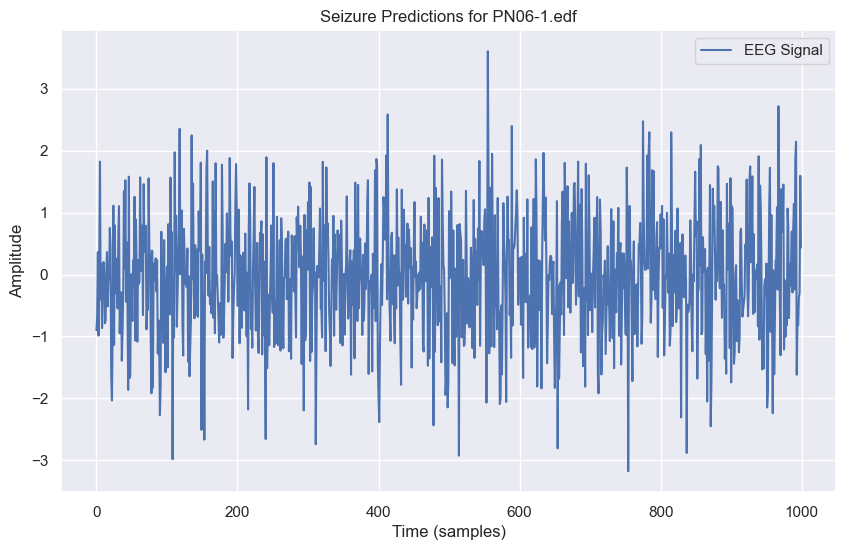

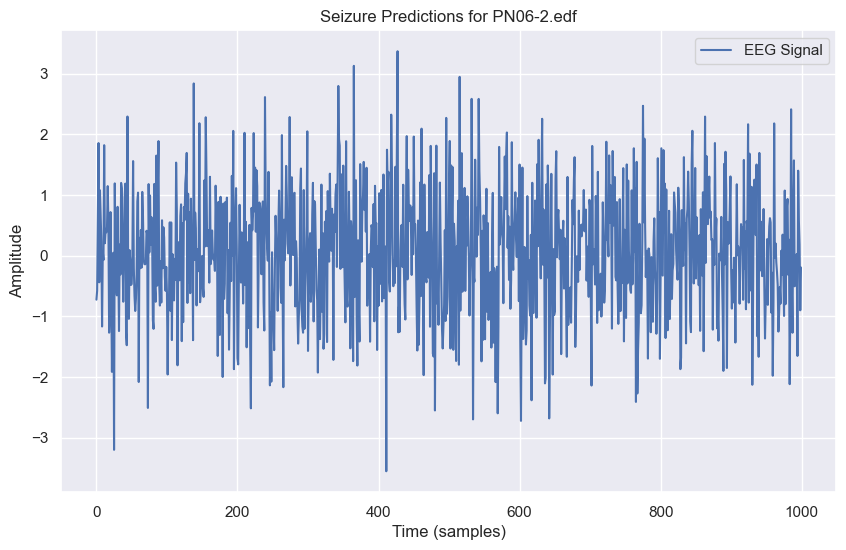

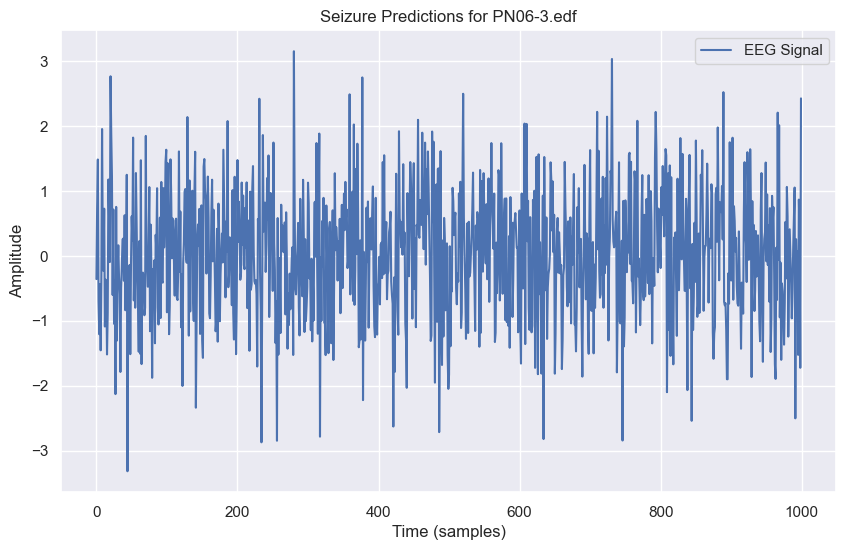

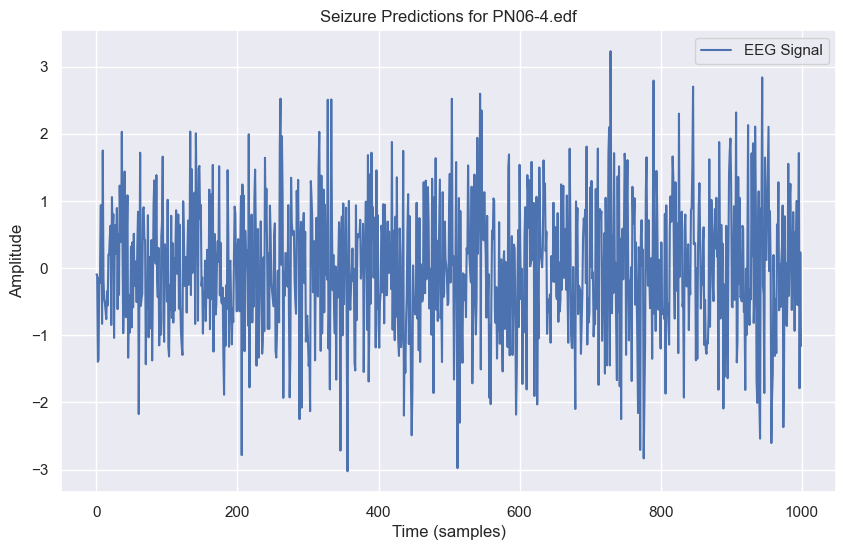

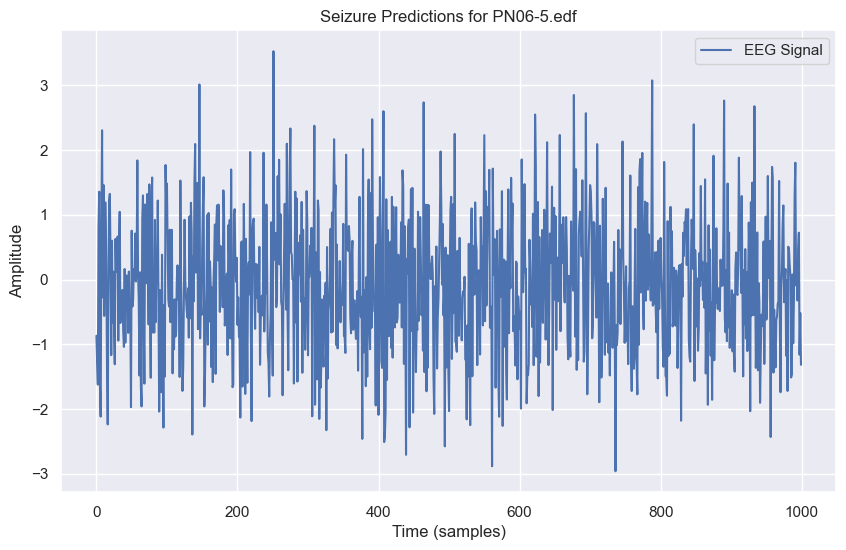

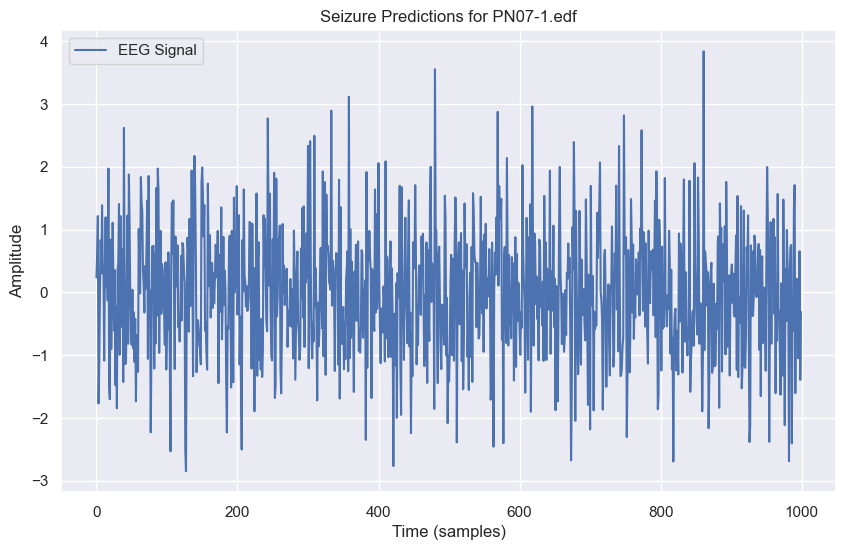

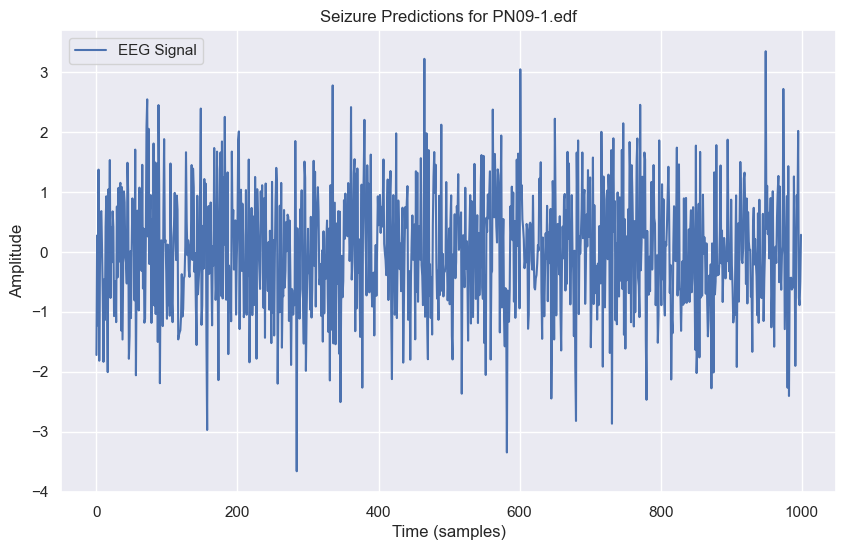

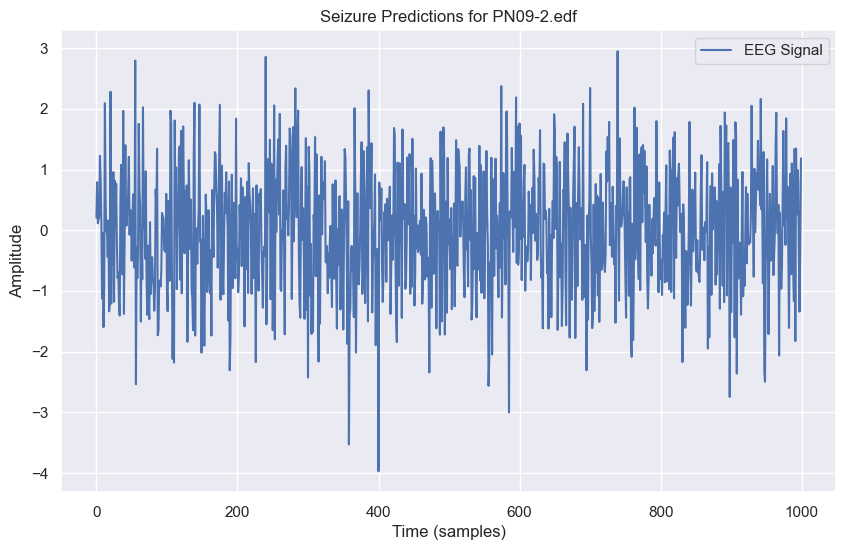

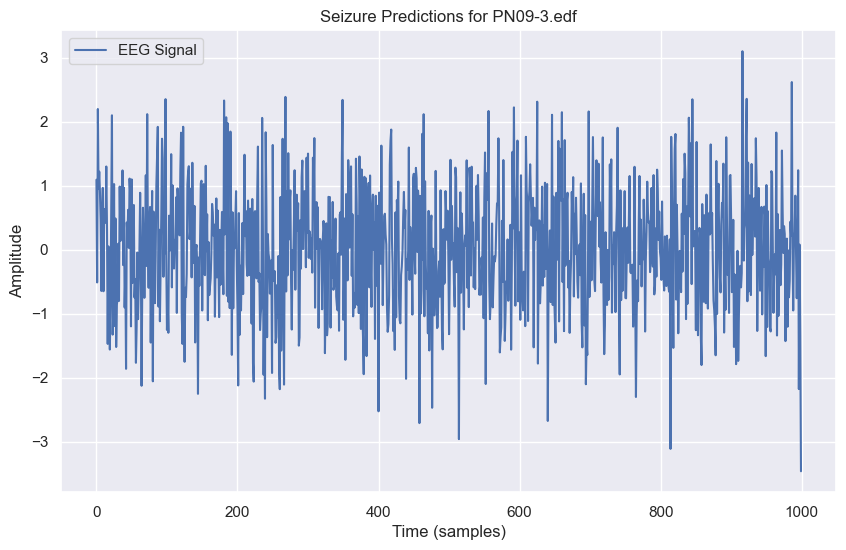

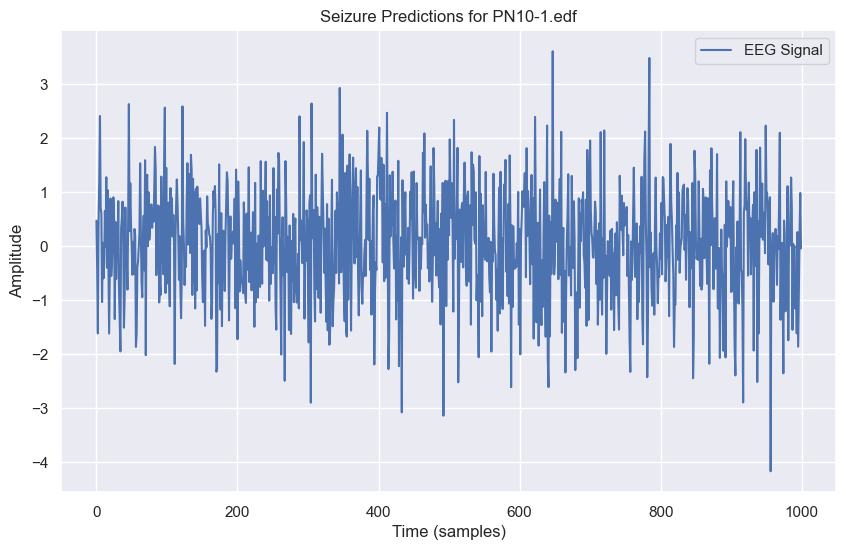

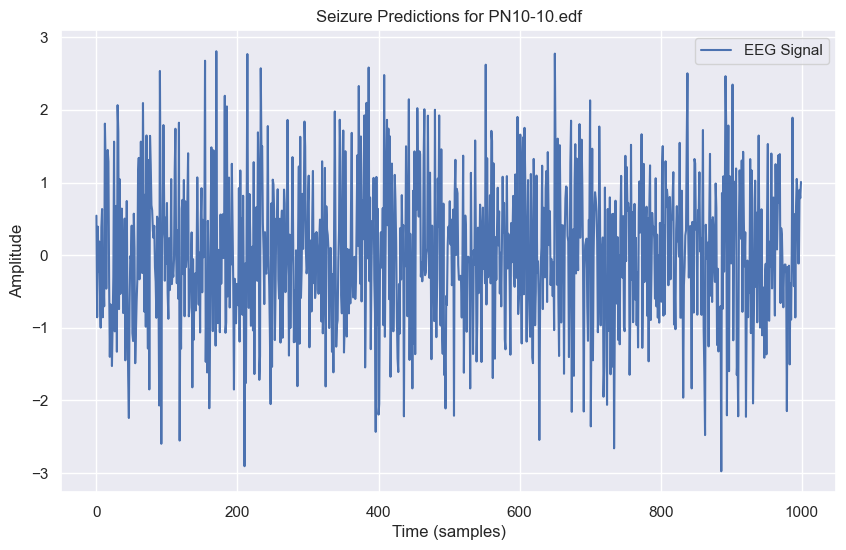

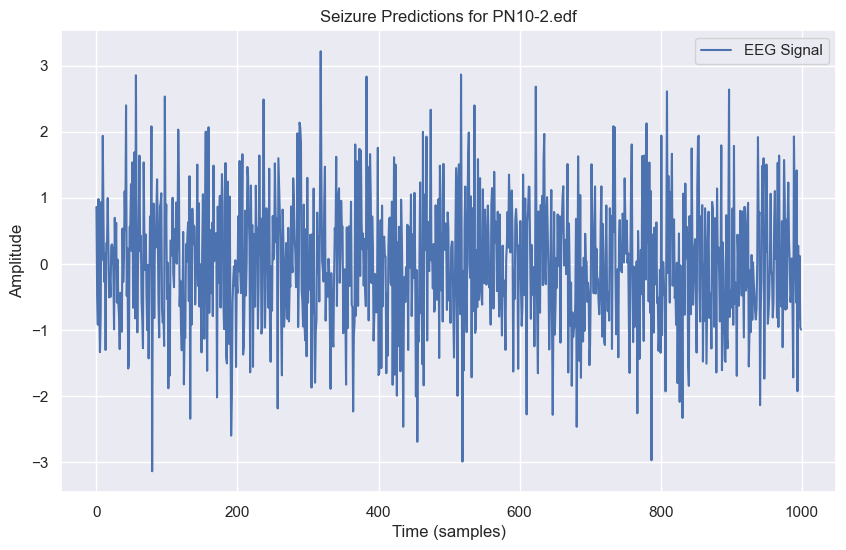

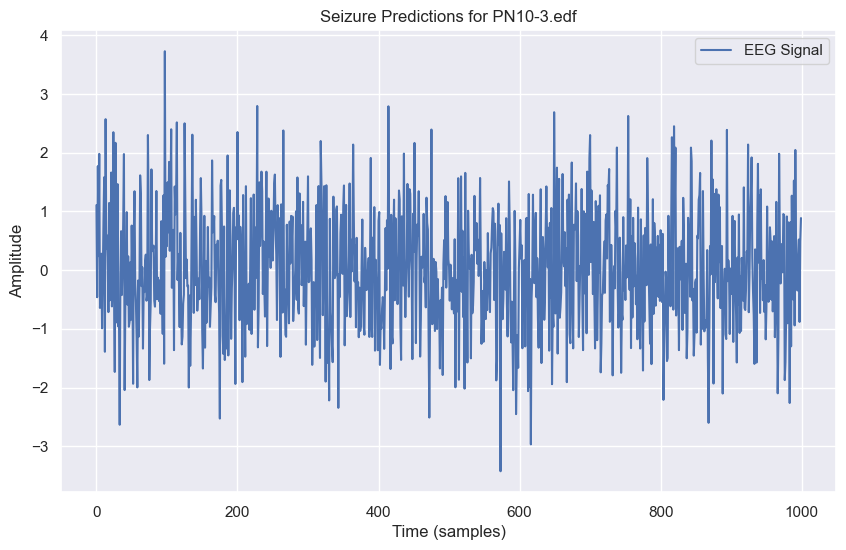

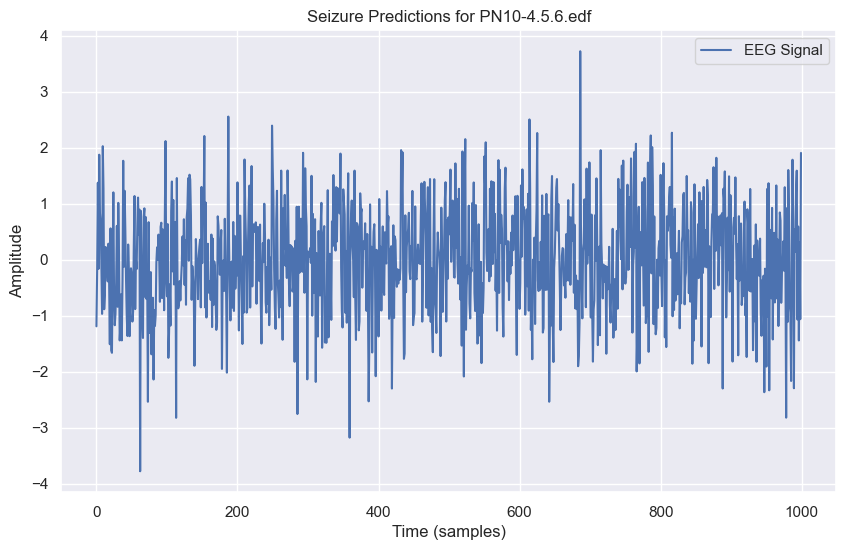

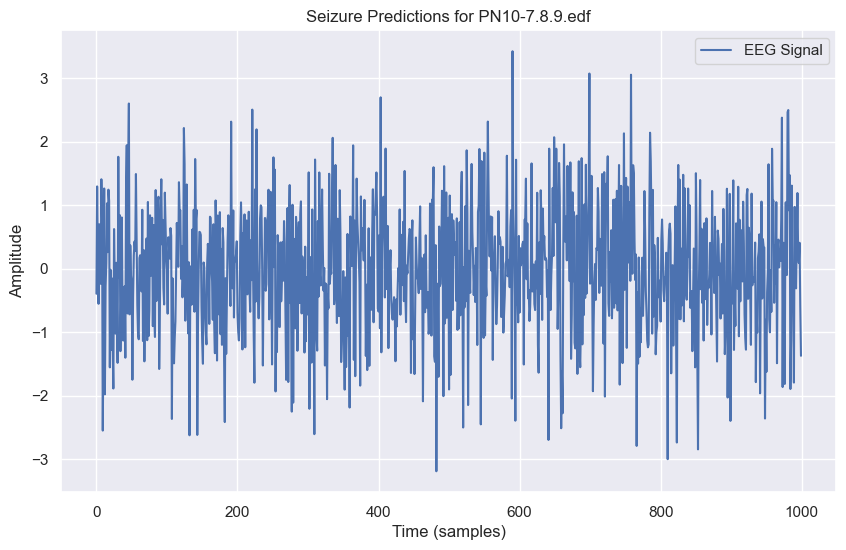

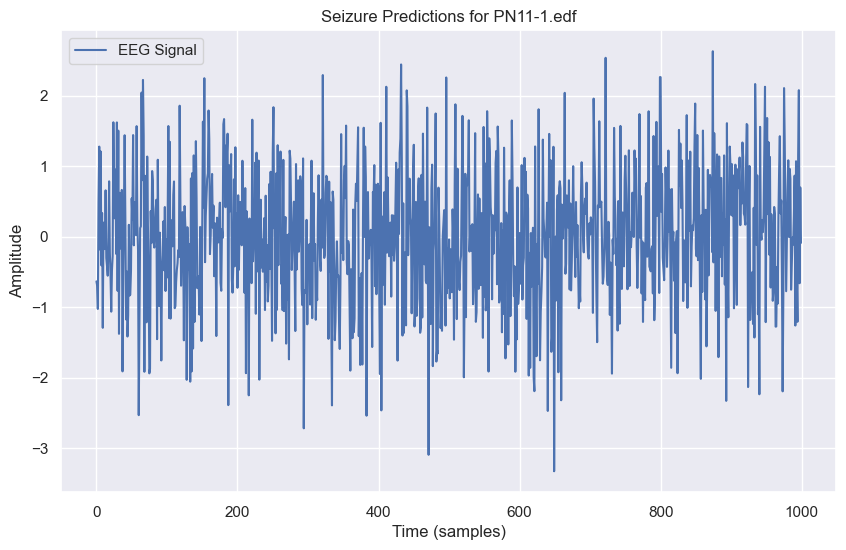

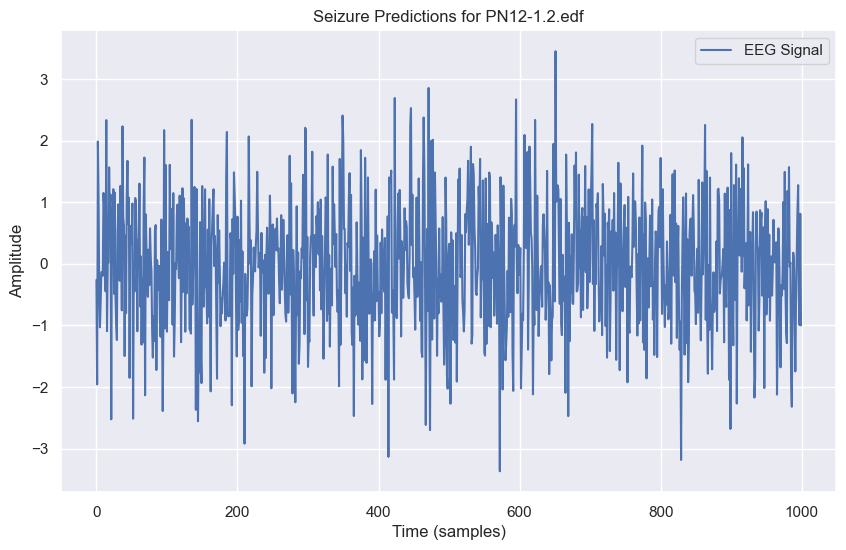

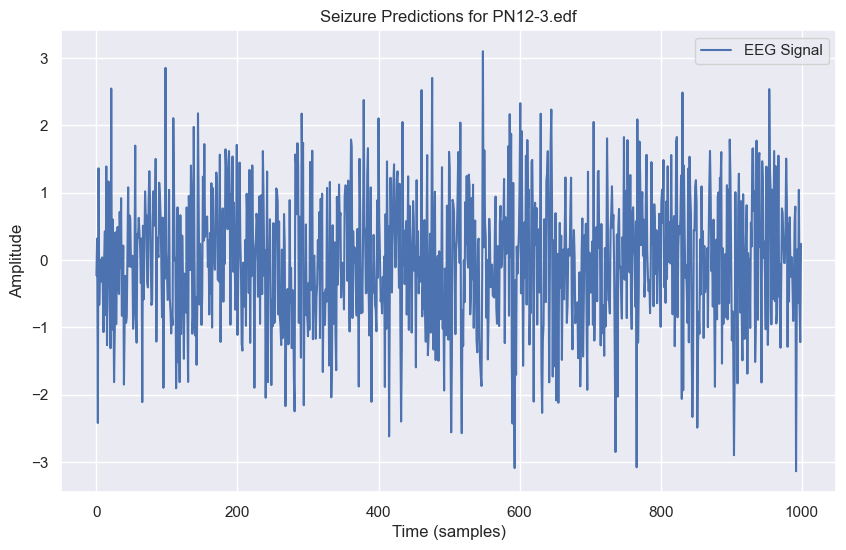

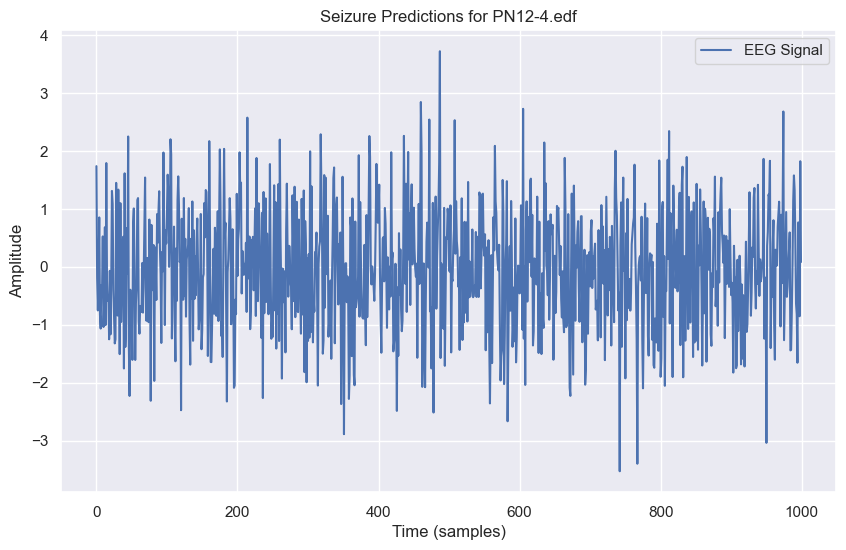

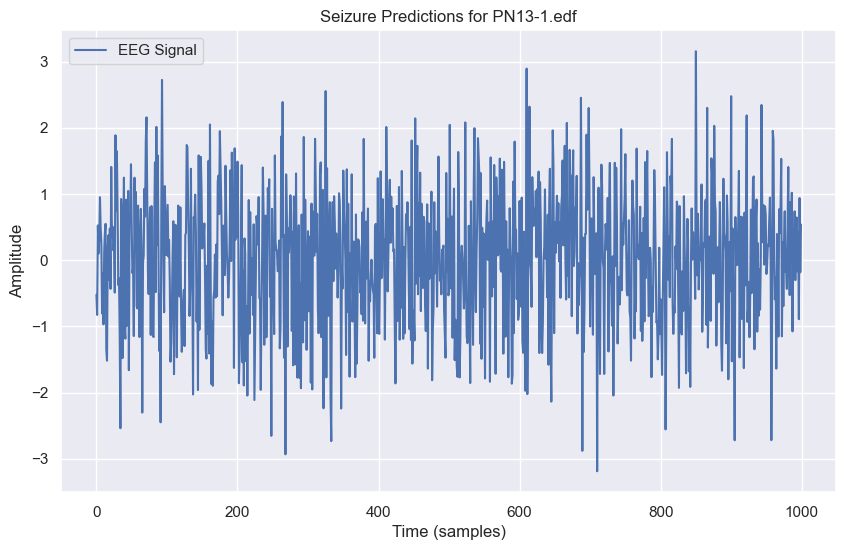

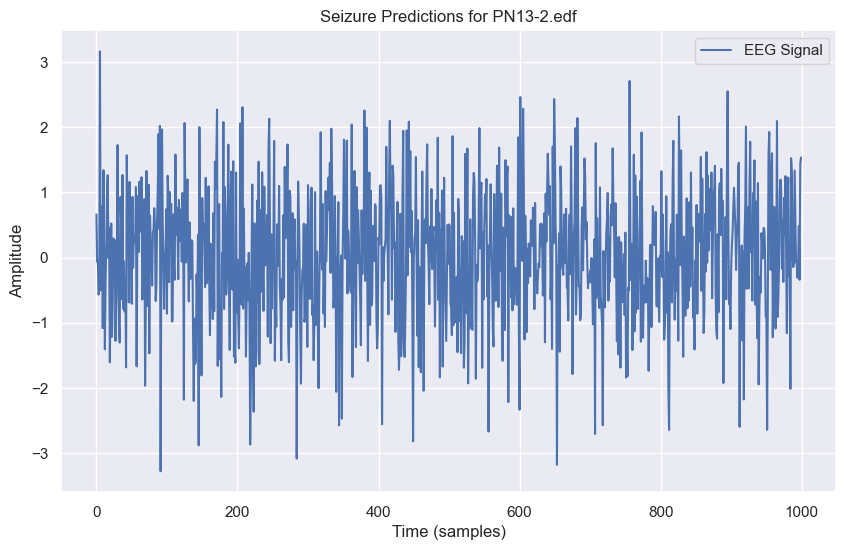

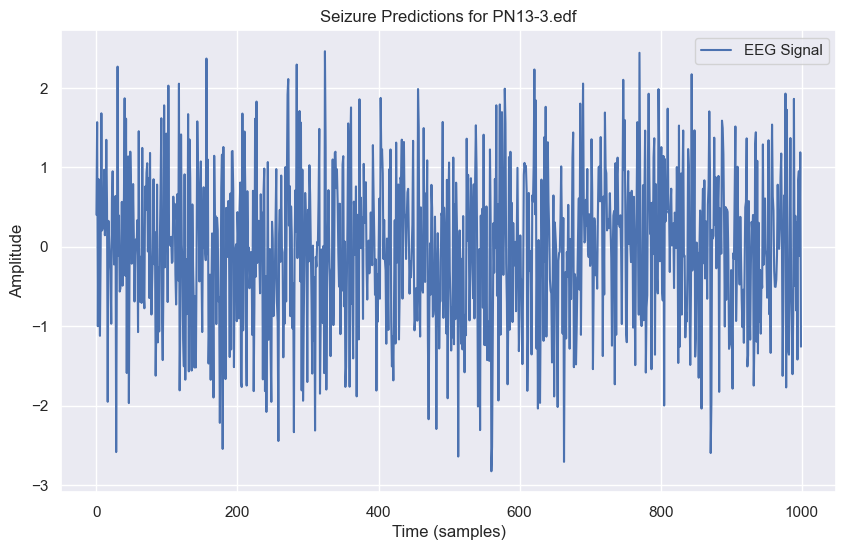

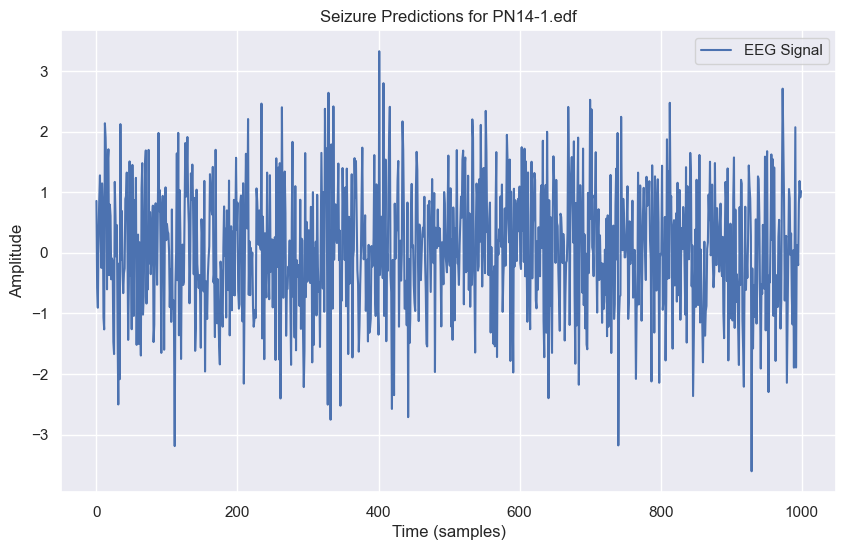

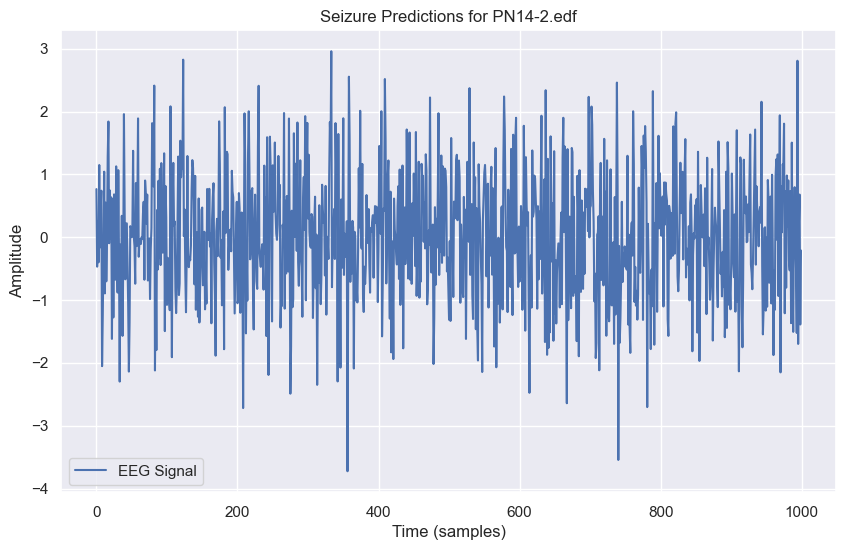

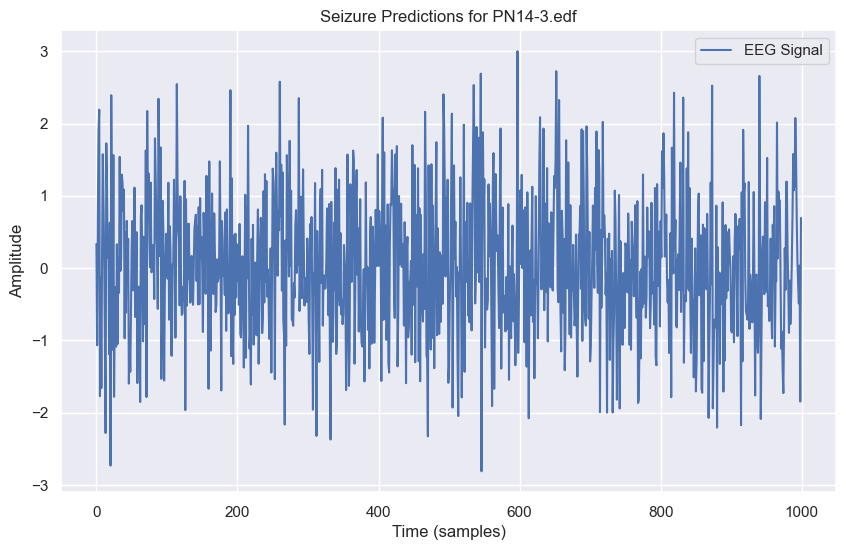

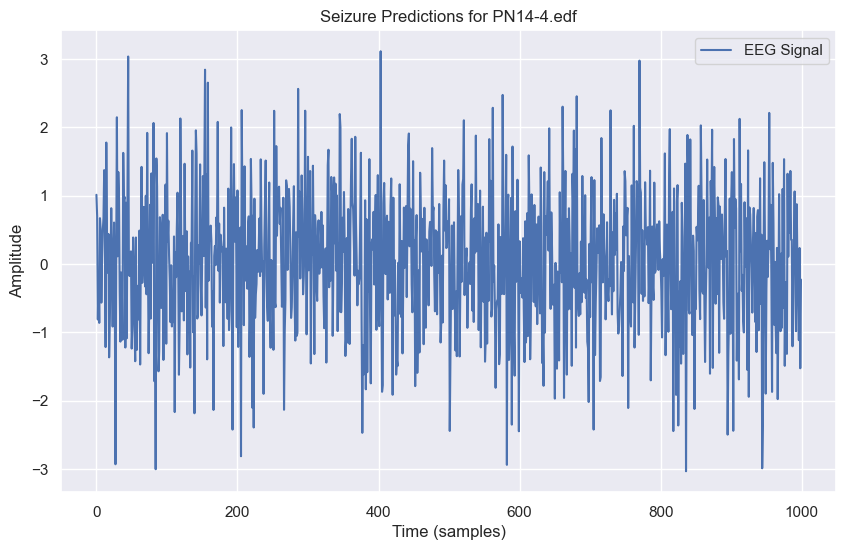

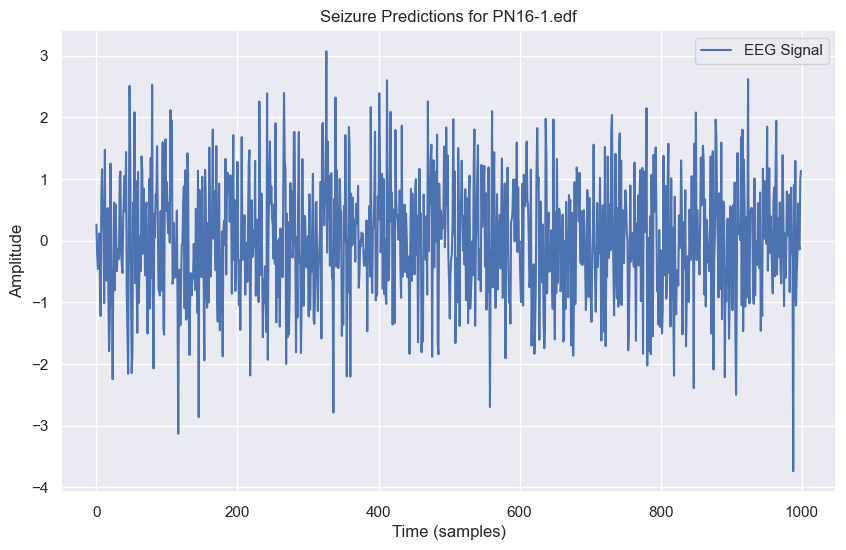

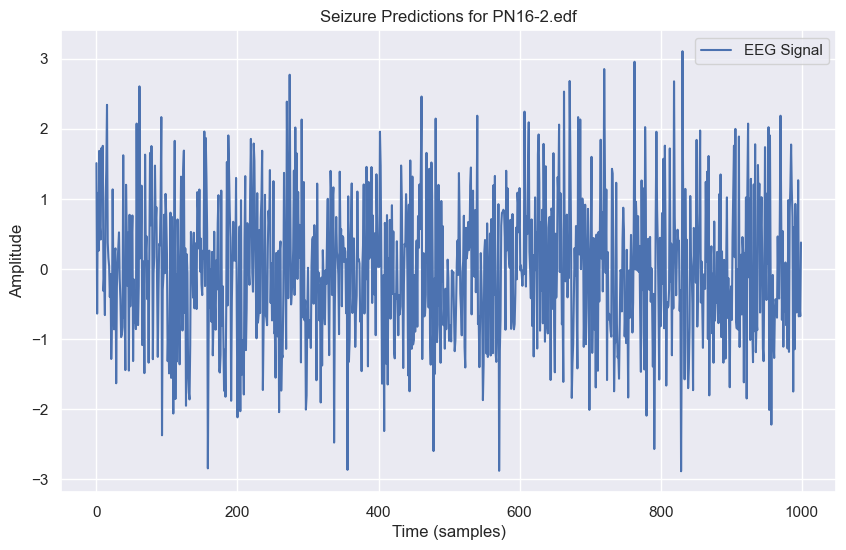

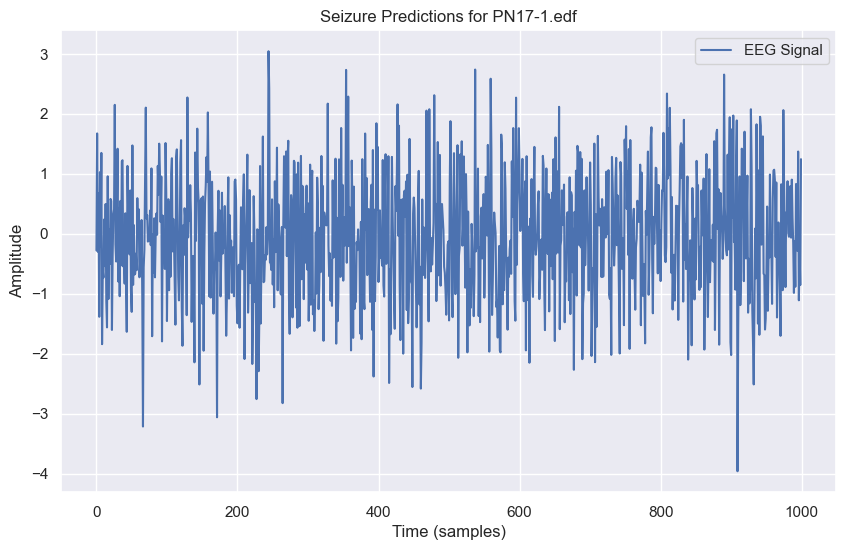

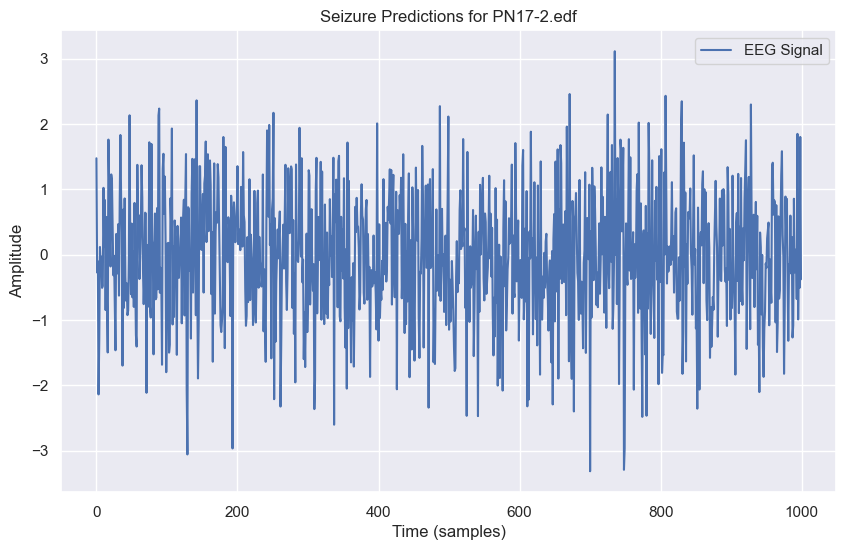

In [52]:
main()

# Testing The Model on EEG EDF to Predict if the Patient have Seizure or Not using RandomForest Algorithm.

In [53]:
import numpy as np
from scipy.stats import skew, kurtosis
from pyedflib import EdfReader
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import joblib
import pandas as pd

- The script creates a synthetic dataset, trains a RandomForestClassifier on it, evaluates the model, makes predictions on subsets of the data, identifies the most important feature, and prints feature importances.
- The trained model is then saved for future use.
- The print statements provide insights into the model's performance and the importance of each feature, which is useful for understanding the model's behavior.

In [54]:
data_features = pd.DataFrame(np.random.rand(1000, 2), columns=['Feature1', 'Feature2'])  # 1000 samples, 2 features each
label_output = np.random.randint(0, 2, 1000)  # Binary target variable

# Train the Random Forest model with 2 features
clf = RandomForestClassifier(n_estimators=100)
clf.fit(data_features, label_output)

# Evaluate the model
y_pred = clf.predict(data_features)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(label_output, y_pred))

# Predictions on subsets of the data
y_pred_normal = clf.predict(data_features.iloc[15:25])
print("Predictions for normal data subset:", y_pred_normal)
y_pred_abnormal = clf.predict(data_features.iloc[0:10])  # Adjusted for correct indexing
print("Predictions for abnormal data subset:", y_pred_abnormal)

# Identify the dominating feature
dominating_feature = data_features.columns[clf.feature_importances_.argmax()]
print("Dominating feature:", dominating_feature)

# Get and print the feature importances
importances = clf.feature_importances_
float_importances = [float(i) * 100 for i in importances]
print("Feature importances:", float_importances)
print("Sum of feature importances:", sum(float_importances))

# Save the trained model
joblib.dump(clf, 'random_forest_model.pkl')


ACCURACY OF THE MODEL:  1.0
Predictions for normal data subset: [0 0 1 1 1 0 1 1 0 0]
Predictions for abnormal data subset: [1 0 0 1 1 0 0 1 1 1]
Dominating feature: Feature1
Feature importances: [50.571147366949795, 49.4288526330502]
Sum of feature importances: 100.0


['random_forest_model.pkl']

- The extract_features function calculates basic statistical features (mean and standard deviation) from each EEG signal.
- The preprocess_edf function reads all signals from an EDF file, preprocesses them, and uses extract_features to obtain the feature set.
- Together, these functions facilitate the conversion of raw EEG data from EDF files into a format that can be used to train machine learning models.

In [55]:
def extract_features(signals):
    features = []
    for signal in signals:
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        features.extend([mean_val, std_val])
    return np.array(features)

# Preprocess the EDF file and extract 2 features
def preprocess_edf(file_path):
    edf = EdfReader(file_path)
    n_signals = edf.signals_in_file
    signals = np.zeros((n_signals, edf.getNSamples()[0]))
    for i in range(n_signals):
        signals[i, :] = edf.readSignal(i)
    features = extract_features(signals)
    return features

- **Load Model**: The pre-trained RandomForestClassifier model is loaded.
- **Preprocess EDF File**: The EDF file is read, and features are extracted.
- **Check Features**: Ensures the extracted features are not empty.
- **Reshape Features**: Adjusts the shape of the features to match the model's input requirements.
- **Make Predictions**: Uses the model to predict whether the EEG signals indicate a seizure and the probability of a seizure.
- **Print Results**: Outputs the prediction and probability to the console.

In [56]:
# Load the pre-trained Random Forest model
model = joblib.load('random_forest_model.pkl')

# Preprocess the healthy patient's EDF file
healthy_features = preprocess_edf('new_siena/healthy_siena/eeg_healthy.edf')

# Check if healthy_features is empty or not
if healthy_features.size == 0:
    raise ValueError("Extracted features from healthy patient's EDF file are empty.")
# Reshape the features array to be 2D
healthy_features = healthy_features.reshape(1, -1)

# Predict using the model
healthy_prediction = model.predict(healthy_features)
healthy_prediction_proba = model.predict_proba(healthy_features)[:, 1]

# Print the results
print("Prediction for healthy patient:", healthy_prediction)
print("Probability of seizure:", healthy_prediction_proba)

Prediction for healthy patient: [1]
Probability of seizure: [0.69]


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


- **Print Predictions**: The script prints the model's prediction and the associated probability of a seizure for the healthy patient.
- **Evaluate Accuracy**: It then evaluates whether the model correctly identified the patient as healthy based on the prediction.
     - If the prediction is 0 (no seizure), the model is deemed correct.
     - If the prediction is 1 (seizure), the model is deemed incorrect.

In [57]:
print("Prediction for healthy patient:", healthy_prediction)
print("Probability of seizure:", healthy_prediction_proba)

if healthy_prediction == 0:
    print("Model correctly identified healthy patient.")
else:
    print("Model incorrectly identified healthy patient as having a seizure.")

Prediction for healthy patient: [1]
Probability of seizure: [0.69]
Model incorrectly identified healthy patient as having a seizure.
